# Marketing Insights for an E-Commerce Company

## Business Objectives

The e-commerce company has provided us with data from one year of transactions and has defined the following requirements in terms of deliverables:

1. Calculate Invoice amount or sale_amount or revenue for each transaction and item level
    * Invoice Value =(( QuantityAvg_price)(1-Dicount_pct)*(1+GST))+Delivery_Charges

2. Detailed exploratory analysis
    * Customers acquired each month
    * Revenue from existing/new customers each month
    * Effect of discounts on revenue
    * Effect of marketing spend on revenue
    * Top products in terms of quantity sold and revenue

3. Customer Segmentation
    * Utilize Heuristic (RFM) and Scientific (K-Means) methods to define customer segments

4. Customer Lifetime Value
    * Define CLV classes for each customer
    * Build classification model

5. Cross-Selling (Which products are selling together)
    * Perform market basket analysis to understand which of items can be bundled together

6. Churn analysis
    * Perform cohort analysis to understand retention on monthly basis


**About the data**

Source: [Marketing Insights for E-Commerce Company on #kaggle via @KaggleDatasets ](https://www.kaggle.com/datasets/rishikumarrajvansh/marketing-insights-for-e-commerce-company?utm_medium=social&utm_campaign=kaggle-dataset-share&utm_source=reddit)

## Data cleaning and preparation

In [2736]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2737]:
# Load datasets
customer = pd.read_excel('Files/CustomersData.xlsx')
discount = pd.read_csv('Files/Discount_Coupon.csv')
marketing = pd.read_csv('Files/Marketing_Spend.csv')
sales = pd.read_csv('Files/Online_Sales.csv')
tax = pd.read_excel('Files/Tax_amount.xlsx')

### Customer dataset

In [2738]:
customer.head()

,CustomerID,Gender,Location,Tenure_Months
0,17850,M,Chicago,12
1,13047,M,California,43
2,12583,M,Chicago,33
3,13748,F,California,30
4,15100,M,California,49


In [2739]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1468 entries, 0 to 1467
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   CustomerID     1468 non-null   int64 
 1   Gender         1468 non-null   object
 2   Location       1468 non-null   object
 3   Tenure_Months  1468 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 46.0+ KB


In [2740]:
# Checking for duplicate customer IDs
print(customer['CustomerID'].duplicated().sum())

0


In [2741]:
# Looing at summary statistics tenure months
customer['Tenure_Months'].describe()

count    1468.000000
mean       25.912125
std        13.959667
min         2.000000
25%        14.000000
50%        26.000000
75%        38.000000
max        50.000000
Name: Tenure_Months, dtype: float64

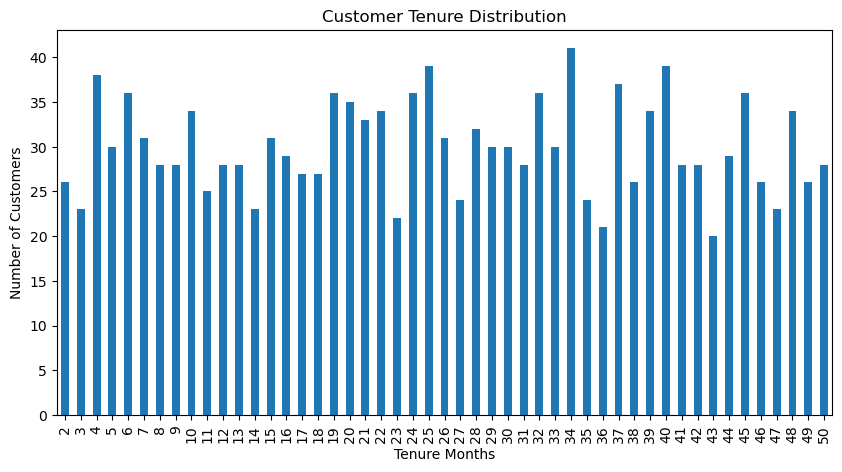

In [2742]:
customer['Tenure_Months'].value_counts().sort_index().plot(kind='bar', figsize=(10,5))
plt.title('Customer Tenure Distribution')
plt.xlabel('Tenure Months')
plt.ylabel('Number of Customers')
plt.show()

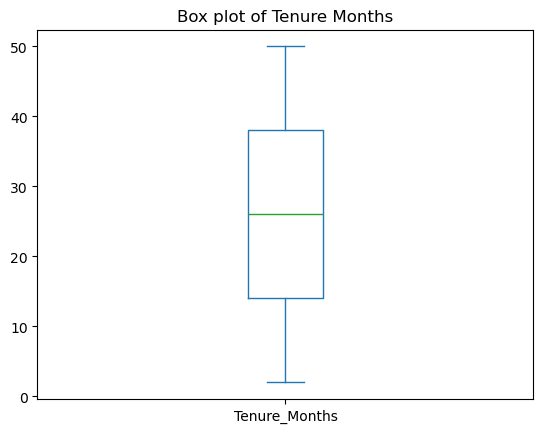

In [2743]:
customer['Tenure_Months'].plot(kind='box')
plt.title('Box plot of Tenure Months')
plt.show()

In [2744]:
# Looking for outliers in 'Tenure_Months' using IQR method
Q1 = customer['Tenure_Months'].quantile(0.25)
Q3 = customer['Tenure_Months'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = customer[(customer['Tenure_Months'] < lower_bound) | (customer['Tenure_Months'] > upper_bound)]
print(f"Number of outliers in 'Tenure_Months': {outliers.shape[0]}")

Number of outliers in 'Tenure_Months': 0


In [2745]:
# Checking for unique values and value counts in categorical columns
for col in ['Gender', 'Location']:
    print(customer[col].unique())
    print("----------")
    print(customer[col].value_counts())
    print("==========")

['M' 'F']
----------
Gender
F    934
M    534
Name: count, dtype: int64
['Chicago' 'California' 'New York' 'New Jersey' 'Washington DC']
----------
Location
California       464
Chicago          456
New York         324
New Jersey       149
Washington DC     75
Name: count, dtype: int64


### Discount dataset

In [2746]:
discount.head()

,Month,Product_Category,Coupon_Code,Discount_pct
0,Jan,Apparel,SALE10,10
1,Feb,Apparel,SALE20,20
2,Mar,Apparel,SALE30,30
3,Jan,Nest-USA,ELEC10,10
4,Feb,Nest-USA,ELEC20,20


In [2747]:
discount.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Month             204 non-null    object
 1   Product_Category  204 non-null    object
 2   Coupon_Code       204 non-null    object
 3   Discount_pct      204 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 6.5+ KB


In [2748]:
# Checking for missing values in discount dataset
discount.isna().sum()

Month               0
Product_Category    0
Coupon_Code         0
Discount_pct        0
dtype: int64

In [2749]:
# Checking if multiple coupon codes were used in the same product category within the same month
codes_per_month = discount.groupby(['Product_Category', 'Month'])['Coupon_Code'].nunique().reset_index(name='Unique_Coupon_Codes')
len(codes_per_month[codes_per_month['Unique_Coupon_Codes'] > 1])




0

In [2750]:
print(discount['Month'].value_counts())

Month
Jan    17
Feb    17
Mar    17
Apr    17
May    17
Jun    17
Jul    17
Aug    17
Sep    17
Oct    17
Nov    17
Dec    17
Name: count, dtype: int64


In [2751]:
# Turning month abbreviations into datetime format
months_dict = {'Jan': '2019-01', 'Feb': '2019-02', 'Mar': '2019-03', 'Apr': '2019-04', 'May': '2019-05', 'Jun': '2019-06', 'Jul': '2019-07', 'Aug': '2019-08', 'Sep': '2019-09', 'Oct': '2019-10', 'Nov': '2019-11', 'Dec': '2019-12'}
discount['Month'] = discount['Month'].map(months_dict)
discount['Month'] = pd.to_datetime(discount['Month'], format='%Y-%m').dt.to_period('M')
discount['Month'].value_counts()


Month
2019-01    17
2019-02    17
2019-03    17
2019-04    17
2019-05    17
2019-06    17
2019-07    17
2019-08    17
2019-09    17
2019-10    17
2019-11    17
2019-12    17
Freq: M, Name: count, dtype: int64

In [2752]:
print(discount['Product_Category'].value_counts())

Product_Category
Apparel                 12
Waze                    12
Notebooks & Journals    12
Gift Cards              12
Accessories             12
Housewares              12
Nest-Canada             12
Bottles                 12
Nest                    12
Nest-USA                12
Headgear                12
Notebooks               12
Bags                    12
Lifestyle               12
Drinkware               12
Office                  12
Android                 12
Name: count, dtype: int64


### Marketing dataset

In [2753]:
marketing.head()

,Date,Offline_Spend,Online_Spend
0,1/1/2019,4500,2424.50
1,1/2/2019,4500,3480.36
2,1/3/2019,4500,1576.38
3,1/4/2019,4500,2928.55
4,1/5/2019,4500,4055.30


In [2754]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           365 non-null    object 
 1   Offline_Spend  365 non-null    int64  
 2   Online_Spend   365 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 8.7+ KB


In [2755]:
# Converting 'Date' column to datetime format
marketing['Date'] = pd.to_datetime(marketing['Date'], format='%m/%d/%Y')
marketing.head()

,Date,Offline_Spend,Online_Spend
0,2019-01-01,4500,2424.50
1,2019-01-02,4500,3480.36
2,2019-01-03,4500,1576.38
3,2019-01-04,4500,2928.55
4,2019-01-05,4500,4055.30


In [2756]:
# Adding Month column to aid future aggregations
marketing['Month'] = marketing['Date'].dt.to_period('M')
marketing.head()

,Date,Offline_Spend,Online_Spend,Month
0,2019-01-01,4500,2424.50,2019-01
1,2019-01-02,4500,3480.36,2019-01
2,2019-01-03,4500,1576.38,2019-01
3,2019-01-04,4500,2928.55,2019-01
4,2019-01-05,4500,4055.30,2019-01


In [2757]:
marketing.describe()

,Date,Offline_Spend,Online_Spend
count,365,365.000000,365.000000
mean,2019-07-02 00:00:00,2843.561644,1905.880740
min,2019-01-01 00:00:00,500.000000,320.250000
25%,2019-04-02 00:00:00,2500.000000,1258.600000
50%,2019-07-02 00:00:00,3000.000000,1881.940000
75%,2019-10-01 00:00:00,3500.000000,2435.120000
max,2019-12-31 00:00:00,5000.000000,4556.930000
std,NaN,952.292448,808.856853


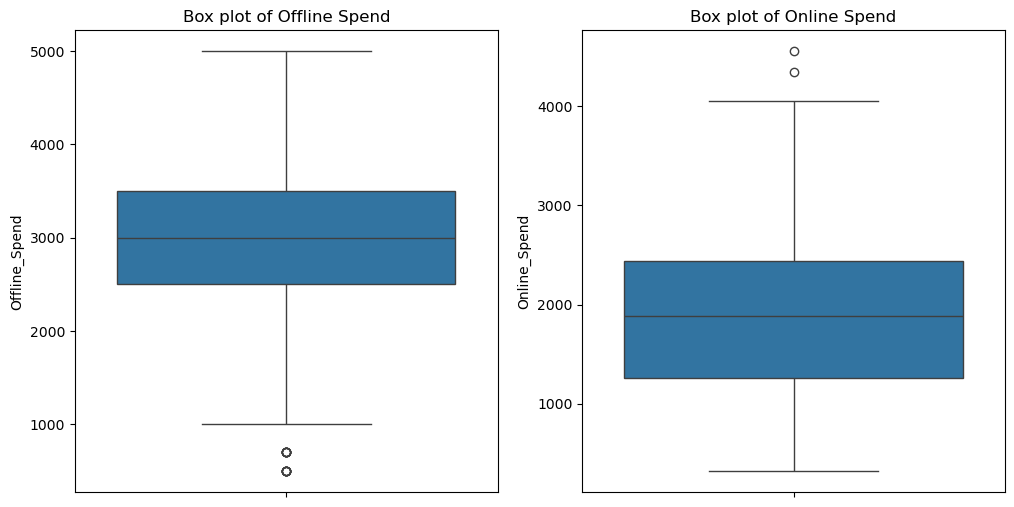

In [2758]:
# Visualizing offline and online spend in box plots for outlier detection
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=marketing['Offline_Spend'])
plt.title('Box plot of Offline Spend')
plt.subplot(1, 2, 2)
sns.boxplot(y=marketing['Online_Spend'])
plt.title('Box plot of Online Spend')
plt.show()

In [2759]:
# Detecting outliers in 'Offline_Spend' using IQR method
Q1_offline = marketing['Offline_Spend'].quantile(0.25)
Q3_offline = marketing['Offline_Spend'].quantile(0.75)
IQR_offline = Q3_offline - Q1_offline
lower_bound_offline = Q1_offline - 1.5 * IQR_offline
upper_bound_offline = Q3_offline + 1.5 * IQR_offline
outliers_offline = marketing[(marketing['Offline_Spend'] < lower_bound_offline) | (marketing['Offline_Spend'] > upper_bound_offline)]
print(f"Number of outliers in 'Offline_Spend': {outliers_offline.shape[0]}")

Number of outliers in 'Offline_Spend': 14


In [2760]:
outliers_offline

,Date,Offline_Spend,Online_Spend,Month
28,2019-01-29,700,836.13,2019-01
29,2019-01-30,700,981.86,2019-01
30,2019-01-31,700,1380.14,2019-01
31,2019-02-01,700,692.67,2019-02
32,2019-02-02,700,770.87,2019-02
33,2019-02-03,700,2091.61,2019-02
34,2019-02-04,700,2216.98,2019-02
147,2019-05-28,500,465.40,2019-05
148,2019-05-29,500,670.64,2019-05
149,2019-05-30,500,1262.38,2019-05


In [2761]:
# Detecting outliers in 'Online_Spend' using IQR method
Q1_online = marketing['Online_Spend'].quantile(0.25)
Q3_online = marketing['Online_Spend'].quantile(0.75)
IQR_online = Q3_online - Q1_online
lower_bound_online = Q1_online - 1.5 * IQR_online
upper_bound_online = Q3_online + 1.5 * IQR_online
outliers_online = marketing[(marketing['Online_Spend'] < lower_bound_online) | (marketing['Online_Spend'] > upper_bound_online)]
print(f"Number of outliers in 'Online_Spend': {outliers_online.shape[0]}")

Number of outliers in 'Online_Spend': 2


In [2762]:
outliers_online

,Date,Offline_Spend,Online_Spend,Month
57,2019-02-27,4000,4349.02,2019-02
332,2019-11-29,3000,4556.93,2019-11


In [2763]:
# Imputing outliers in Offline_Spend na Online_Spend with lower bound and upper bound values
marketing.loc[marketing['Offline_Spend'] < lower_bound_offline, 'Offline_Spend'] = lower_bound_offline
marketing.loc[marketing['Online_Spend'] > upper_bound_online, 'Online_Spend'] = upper_bound_online

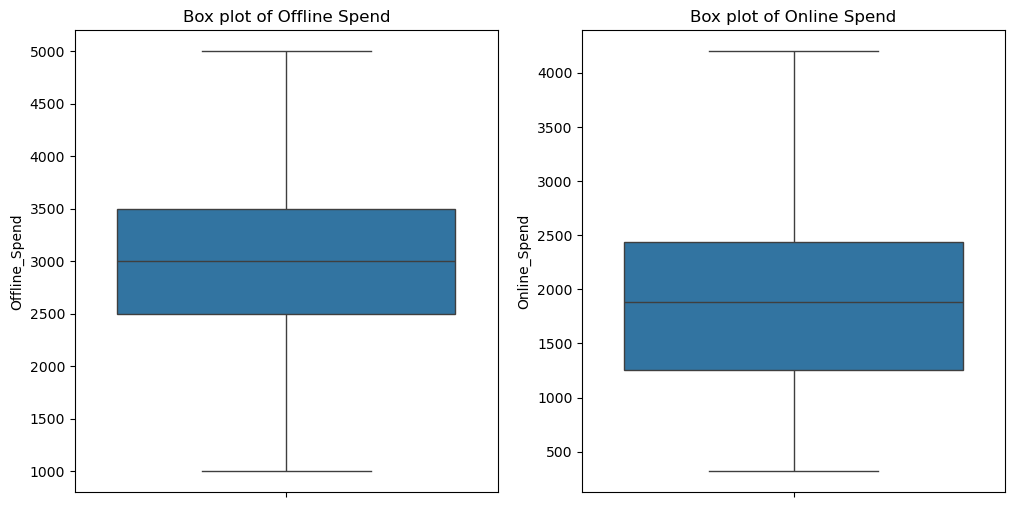

In [2764]:
# Visualizing offline and online spend in box plots after outlier imputation
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=marketing['Offline_Spend'])
plt.title('Box plot of Offline Spend')
plt.subplot(1, 2, 2)
sns.boxplot(y=marketing['Online_Spend'])
plt.title('Box plot of Online Spend')
plt.show()

### Tax dataset

In [2765]:
tax.head()

,Product_Category,GST
0,Nest-USA,0.10
1,Office,0.10
2,Apparel,0.18
3,Bags,0.18
4,Drinkware,0.18


In [2766]:
tax.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Product_Category  20 non-null     object 
 1   GST               20 non-null     float64
dtypes: float64(1), object(1)
memory usage: 452.0+ bytes


In [2767]:
tax.value_counts()

Product_Category      GST 
Accessories           0.10    1
Android               0.10    1
Office                0.10    1
Notebooks & Journals  0.05    1
Nest-USA              0.10    1
Nest-Canada           0.10    1
Nest                  0.05    1
More Bags             0.18    1
Lifestyle             0.18    1
Housewares            0.12    1
Headgear              0.05    1
Google                0.10    1
Gift Cards            0.05    1
Fun                   0.18    1
Drinkware             0.18    1
Bottles               0.05    1
Bags                  0.18    1
Backpacks             0.10    1
Apparel               0.18    1
Waze                  0.18    1
Name: count, dtype: int64

### Sales dataset

In [2768]:
sales.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status
0,17850,16679,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used
1,17850,16680,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used
2,17850,16681,1/1/2019,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used
3,17850,16682,1/1/2019,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.5,Not Used
4,17850,16682,1/1/2019,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used


In [2769]:
sales.dtypes

CustomerID               int64
Transaction_ID           int64
Transaction_Date        object
Product_SKU             object
Product_Description     object
Product_Category        object
Quantity                 int64
Avg_Price              float64
Delivery_Charges       float64
Coupon_Status           object
dtype: object

In [2770]:
# Converting 'Transaction_Date' to datetime format and adding 'Month' column
sales['Transaction_Date'] = pd.to_datetime(sales['Transaction_Date'], format='%m/%d/%Y')
sales['Month'] = sales['Transaction_Date'].dt.to_period('M')
sales.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Month
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,2019-01
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,2019-01
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used,2019-01
3,17850,16682,2019-01-01,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.5,Not Used,2019-01
4,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used,2019-01


In [2771]:
sales.describe()

,CustomerID,Transaction_ID,Transaction_Date,Quantity,Avg_Price,Delivery_Charges
count,52924.00000,52924.000000,52924,52924.000000,52924.000000,52924.000000
mean,15346.70981,32409.825675,2019-07-05 19:16:09.450532864,4.497638,52.237646,10.517630
min,12346.00000,16679.000000,2019-01-01 00:00:00,1.000000,0.390000,0.000000
25%,13869.00000,25384.000000,2019-04-12 00:00:00,1.000000,5.700000,6.000000
50%,15311.00000,32625.500000,2019-07-13 00:00:00,1.000000,16.990000,6.000000
75%,16996.25000,39126.250000,2019-09-27 00:00:00,2.000000,102.130000,6.500000
max,18283.00000,48497.000000,2019-12-31 00:00:00,900.000000,355.740000,521.360000
std,1766.55602,8648.668977,NaN,20.104711,64.006882,19.475613


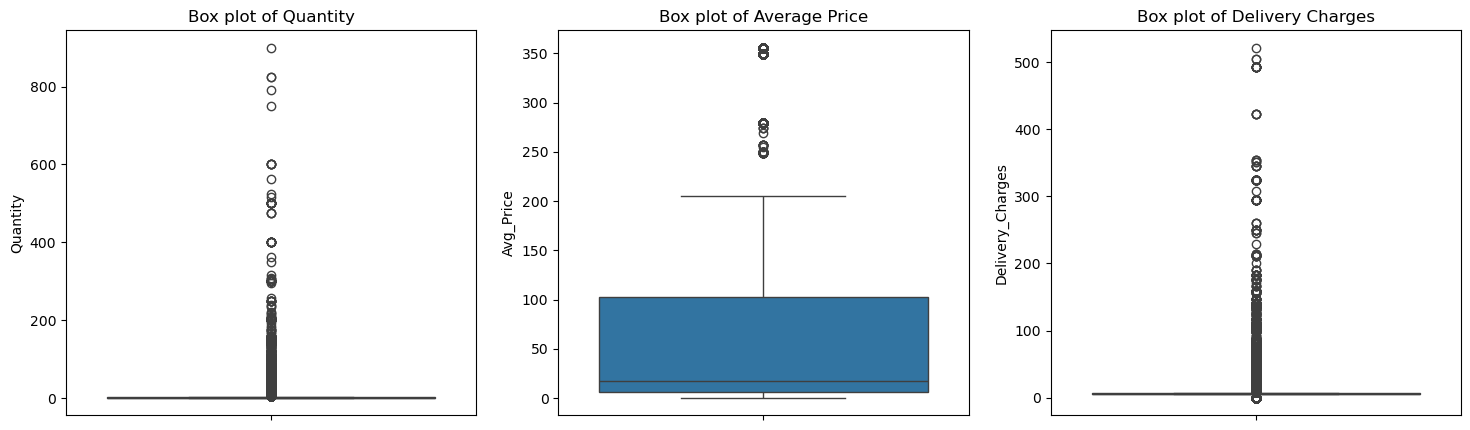

In [2772]:
# Detecting outliers in Quantity, Avg_Price and Delivery_Charges using box plots
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.boxplot(y=sales['Quantity'])
plt.title('Box plot of Quantity')
plt.subplot(1, 3, 2)
sns.boxplot(y=sales['Avg_Price'])
plt.title('Box plot of Average Price')
plt.subplot(1, 3, 3)
sns.boxplot(y=sales['Delivery_Charges'])
plt.title('Box plot of Delivery Charges')
plt.show()

In [2773]:
# Detecting outliers in Quantity using IQR method
Q1_qty = sales['Quantity'].quantile(0.25)
Q3_qty = sales['Quantity'].quantile(0.75)
IQR_qty = Q3_qty - Q1_qty
lower_bound_qty = Q1_qty - 1.5 * IQR_qty
upper_bound_qty = Q3_qty + 1.5 * IQR_qty
print(f"Lower bound for 'Quantity': {lower_bound_qty}"
      f"\nUpper bound for 'Quantity': {upper_bound_qty}")
outliers_qty = sales[(sales['Quantity'] < lower_bound_qty) | (sales['Quantity'] > upper_bound_qty)]
print(f"Number of outliers in 'Quantity': {outliers_qty.shape[0]}")

Lower bound for 'Quantity': -0.5
Upper bound for 'Quantity': 3.5
Number of outliers in 'Quantity': 8284


In [2774]:
# Checking if the highest values in Quantity make common sense
outliers_qty.groupby('Product_Description')['Quantity'].max().sort_values(ascending=False).head(10)

Product_Description
Maze Pen                                 900
Google Blackout Cap                      791
Google Sunglasses                        750
Collapsible Shopping Bag                 600
Leatherette Journal                      600
Google Laptop and Cell Phone Stickers    600
Sport Bag                                563
Google Kick Ball                         500
Google Spiral Journal with Pen           500
Pen Pencil & Highlighter Set             500
Name: Quantity, dtype: int64

In [2775]:
# Checking for outliers on a product level for products with high quantities sold

high_quantity_products = sales[sales['Quantity'] > upper_bound_qty].sort_values('Quantity', ascending=False)['Product_Description'].unique()
high_quantity_outliers = []
for product in high_quantity_products:
    Q1 = sales[sales['Product_Description'] == product]['Quantity'].quantile(0.25)
    Q3 = sales[sales['Product_Description'] == product]['Quantity'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = sales[(sales['Product_Description'] == product) & ((sales['Quantity'] < lower_bound) | (sales['Quantity'] > upper_bound))].shape[0]
    none_outliers = sales[(sales['Product_Description'] == product) & ((sales['Quantity'] >= lower_bound) & (sales['Quantity'] <= upper_bound))].shape[0]
    high_quantity_outliers.append({'Product_Description' : product,
                                   'N_Outliers': outliers,
                                   'N_Non_Outliers': none_outliers
                                   })
high_quantity_outliers_df = pd.DataFrame(high_quantity_outliers).sort_values('N_Outliers', ascending=False).reset_index(drop=True)
print(high_quantity_outliers_df)

                                   Product_Description  N_Outliers  \
0    Nest Learning Thermostat 3rd Gen-USA - Stainle...         783   
1         Nest Learning Thermostat 3rd Gen-USA - White         219   
2                                    Google Sunglasses         204   
3                              Nest Thermostat E - USA         189   
4               Nest Cam Outdoor Security Camera - USA         139   
..                                                 ...         ...   
299                          YouTube Kids Onesie White           0   
300            Google Insulated Stainless Steel Bottle           0   
301  Google Women's Short Sleeve Performance Tee Black           0   
302                 YouTube Transmission Journal Black           0   
303         Google Women's Performance Polo Grey/Black           0   

     N_Non_Outliers  
0              2728  
1               870  
2              1319  
3               655  
4              3189  
..              ...  
299  

We'll leave these outliers for now. Without the possiblity to verify a sample of these outliers, there's a very real risk of removing real data.

In [2776]:
# Detecting outliers in 'Average_Price' using IQR method
Q1_price = sales['Avg_Price'].quantile(0.25)
Q3_price = sales['Avg_Price'].quantile(0.75)
IQR_price = Q3_price - Q1_price
lower_bound_price = Q1_price - 1.5 * IQR_price
upper_bound_price = Q3_price + 1.5 * IQR_price
print(f"Lower bound for 'Avg_Price': {lower_bound_price}"
      f"\nUpper bound for 'Avg_Price': {upper_bound_price}")
outliers_price = sales[(sales['Avg_Price'] < lower_bound_price) | (sales['Avg_Price'] > upper_bound_price)]
print(f"Number of outliers in 'Avg_Price': {outliers_price.shape[0]}")   

Lower bound for 'Avg_Price': -138.945
Upper bound for 'Avg_Price': 246.77499999999998
Number of outliers in 'Avg_Price': 728


In [2777]:
# Checking if the highest values in Average Price make common sense
outliers_price.groupby('Product_Description')['Avg_Price'].max().sort_values(ascending=False)

Product_Description
Nest Secure Alarm System Starter Pack - USA               355.74
Nest Cam IQ Outdoor - USA (Preorder)                      349.00
Nest Cam IQ - CA                                          274.19
Nest Learning Thermostat 3rd Gen-USA - Stainless Steel    256.88
Gift Card - $250.00                                       254.82
Nest Learning Thermostat 3rd Gen-USA - White              249.00
Name: Avg_Price, dtype: float64

In [2778]:
# Checking for outliers in 'Avg_Price' on a product level

high_price_products = sales[sales['Avg_Price'] > upper_bound_price].sort_values('Avg_Price', ascending=False)['Product_Description'].unique()
high_price_outliers = []
for product in high_price_products:
    Q1 = sales[sales['Product_Description'] == product]['Avg_Price'].quantile(0.25)
    Q3 = sales[sales['Product_Description'] == product]['Avg_Price'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = sales[(sales['Product_Description'] == product) & ((sales['Avg_Price'] < lower_bound) | (sales['Avg_Price'] > upper_bound))].shape[0]
    none_outliers = sales[(sales['Product_Description'] == product) & ((sales['Avg_Price'] >= lower_bound) & (sales['Avg_Price'] <= upper_bound))].shape[0]
    high_price_outliers.append({'Product_Description' : product,
                                   'N_Outliers': outliers,
                                   'N_Non_Outliers': none_outliers
                                   })
high_price_outliers_df = pd.DataFrame(high_price_outliers).sort_values('N_Outliers', ascending=False).reset_index(drop=True)
print(high_price_outliers_df)

                                 Product_Description  N_Outliers  \
0       Nest Learning Thermostat 3rd Gen-USA - White         210   
1  Nest Learning Thermostat 3rd Gen-USA - Stainle...          33   
2               Nest Cam IQ Outdoor - USA (Preorder)           1   
3                                   Nest Cam IQ - CA           1   
4                                Gift Card - $250.00           1   
5        Nest Secure Alarm System Starter Pack - USA           0   

   N_Non_Outliers  
0             879  
1            3478  
2             147  
3               3  
4              44  
5             498  


We'll leave these outliers for now. Without the possiblity to verify a sample of these outliers, there's a very real risk of removing real data.

In [2779]:
# Detecting outliers in 'Delivery_Charges' using IQR method
Q1_delv = sales['Delivery_Charges'].quantile(0.25)
Q3_delv = sales['Delivery_Charges'].quantile(0.75)
IQR_delv = Q3_delv - Q1_delv
lower_bound_delv = Q1_delv - 1.5 * IQR_delv
upper_bound_delv = Q3_delv + 1.5 * IQR_delv
print(f"Lower bound for 'Delivery_Charges': {lower_bound_delv}"
      f"\nUpper bound for 'Delivery_Charges': {upper_bound_delv}")
outliers_delv = sales[(sales['Delivery_Charges'] < lower_bound_delv) | (sales['Delivery_Charges'] > upper_bound_delv)]
print(f"Number of outliers in 'Delivery_Charges': {outliers_delv.shape[0]}")

Lower bound for 'Delivery_Charges': 5.25
Upper bound for 'Delivery_Charges': 7.25
Number of outliers in 'Delivery_Charges': 10243


In [2780]:
# Checking if the highest values in Delivery Charges make common sense
outliers_delv.groupby('Product_Description')['Delivery_Charges'].max().sort_values(ascending=False).head(10)

Product_Description
Google Spiral Leather Journal                521.36
Ballpoint LED Light Pen                      504.00
Four Color Retractable Pen                   504.00
Google Men's Quilted Insulated Vest Black    492.84
Google Zipper-front Sports Bag               492.84
Google Hard Cover Journal                    492.84
Google Canvas Tote Natural/Navy              492.84
26 oz Double Wall Insulated Bottle           492.84
Google Sunglasses                            492.84
Google Stylus Pen w/ LED Light               492.84
Name: Delivery_Charges, dtype: float64

In [2781]:
# Cecking for outliers in Delivery Charges on a product level
high_delv_products = sales[sales['Delivery_Charges'] > upper_bound_delv].sort_values('Delivery_Charges', ascending=False)['Product_Description'].unique()
high_delv_outliers = []
for product in high_delv_products:
    Q1 = sales[sales['Product_Description'] == product]['Delivery_Charges'].quantile(0.25)
    Q3 = sales[sales['Product_Description'] == product]['Delivery_Charges'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = sales[(sales['Product_Description'] == product) & ((sales['Delivery_Charges'] < lower_bound) | (sales['Delivery_Charges'] > upper_bound))].shape[0]
    none_outliers = sales[(sales['Product_Description'] == product) & ((sales['Delivery_Charges'] >= lower_bound) & (sales['Delivery_Charges'] <= upper_bound))].shape[0]
    high_delv_outliers.append({'Product_Description' : product,
                                   'N_Outliers': outliers,
                                   'N_Non_Outliers': none_outliers
                                   })
high_delv_outliers_df = pd.DataFrame(high_delv_outliers).sort_values('N_Outliers', ascending=False).reset_index(drop=True)
print(high_delv_outliers_df)

                                   Product_Description  N_Outliers  \
0               Nest Cam Outdoor Security Camera - USA         361   
1                Nest Cam Indoor Security Camera - USA         274   
2    Nest Learning Thermostat 3rd Gen-USA - Stainle...         248   
3                                    Google Sunglasses         188   
4                Google Laptop and Cell Phone Stickers         182   
..                                                 ...         ...   
372                            Android 5-Panel Low Cap           0   
373                                    Straw Beach Mat           0   
374  YouTube Men's Long Sleeve Pullover Badge Tee H...           0   
375  Android Women's Short Sleeve Tri-blend Badge T...           0   
376     Nest Protect Smoke + CO White Wired Alarm - CA           0   

     N_Non_Outliers  
0              2967  
1              2956  
2              3263  
3              1335  
4               624  
..              ...  
372  

We'll leave these outliers for now. Without the possiblity to verify a sample of these outliers, there's a very real risk of removing real data.

## 1 Invoice value

The e-commerce company wants us to calculate the Invoice amount for each transaction and item level

    * Invoice Value =(( QuantityAvg_price)(1-Dicount_pct)*(1+GST))+Delivery_Charges

In [2782]:
sales_v2 = sales.copy()

In [2783]:
# Getting Discount_pct into sales dataset for items where coupon was used
discount_sales = sales_v2[sales_v2['Coupon_Status'] == 'Used']
normal_sales = sales_v2[(sales_v2['Coupon_Status'] == 'Not Used') | (sales_v2['Coupon_Status'] == 'Clicked')]

discount_sales = discount_sales.merge(discount[['Product_Category', 'Month', 'Discount_pct']], how='left', on=['Product_Category', 'Month'])

normal_sales['Discount_pct'] = 0

sales_v2 = pd.concat([discount_sales, normal_sales], ignore_index=True)

In [2784]:
# Changing Discount_pct to decimal for easier calculations later

sales_v2['Discount_pct'] = sales_v2['Discount_pct'] / 100

In [2785]:
# Getting GST into sales dataset
sales_v2 = sales_v2.merge(tax[['Product_Category', 'GST']], how='left', on='Product_Category')


In [2786]:
sales_v2.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Month,Discount_pct,GST
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,2019-01,0.1,0.10
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,2019-01,0.1,0.10
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used,2019-01,0.1,0.10
3,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used,2019-01,0.1,0.18
4,17850,16682,2019-01-01,GGOEGBMJ013399,Sport Bag,Bags,15,5.15,6.5,Used,2019-01,0.1,0.18


In [2787]:
# Calculating sale_amount on item level
sales_v2['Sale_Amount'] = round(((sales_v2['Quantity'] * sales_v2['Avg_Price']) * (1 - sales_v2['Discount_pct']) * (1 + sales_v2['GST']) + sales_v2['Delivery_Charges']), ndigits=2)
sales_v2.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Month,Discount_pct,GST,Sale_Amount
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,2019-01,0.1,0.10,158.67
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,2019-01,0.1,0.10,158.67
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used,2019-01,0.1,0.10,8.53
3,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used,2019-01,0.1,0.18,24.02
4,17850,16682,2019-01-01,GGOEGBMJ013399,Sport Bag,Bags,15,5.15,6.5,Used,2019-01,0.1,0.18,88.54


In [2788]:
# Calculating invoice amount on a transaction level
transaction_sales = sales_v2.groupby('Transaction_ID').agg({'Sale_Amount': 'sum'}).reset_index()
transaction_sales.rename(columns={'Sale_Amount': 'Invoice_Amount'}, inplace=True)
transaction_sales.head()

,Transaction_ID,Invoice_Amount
0,16679,158.67
1,16680,158.67
2,16681,8.53
3,16682,833.47
4,16684,363.78


## 2 Detailed exploratory analysis

### 2.1 Customer acquisition

In [2789]:
# Find the first month a customer made a purchase in the dataset
first_sale = sales_v2.groupby('CustomerID', as_index=False).agg(Acquisition_Month_Sales =('Month', 'min'))
first_sale.head()

,CustomerID,Acquisition_Month_Sales
0,12346,2019-09
1,12347,2019-03
2,12348,2019-06
3,12350,2019-12
4,12356,2019-09


In [2790]:
# Adding first month of purchase to customer dataset
customer_v2 = customer.copy()
customer_v3 = customer_v2.merge(first_sale, how='left', on='CustomerID')
customer_v3.head()

,CustomerID,Gender,Location,Tenure_Months,Acquisition_Month_Sales
0,17850,M,Chicago,12,2019-01
1,13047,M,California,43,2019-01
2,12583,M,Chicago,33,2019-01
3,13748,F,California,30,2019-01
4,15100,M,California,49,2019-01


In [2791]:
# Creating seperate dataframe for acquisition counts
acq_counts = (
    customer_v3
    .groupby('Acquisition_Month_Sales')
    .size()
    .reset_index(name='count')
    .sort_values('Acquisition_Month_Sales')
)

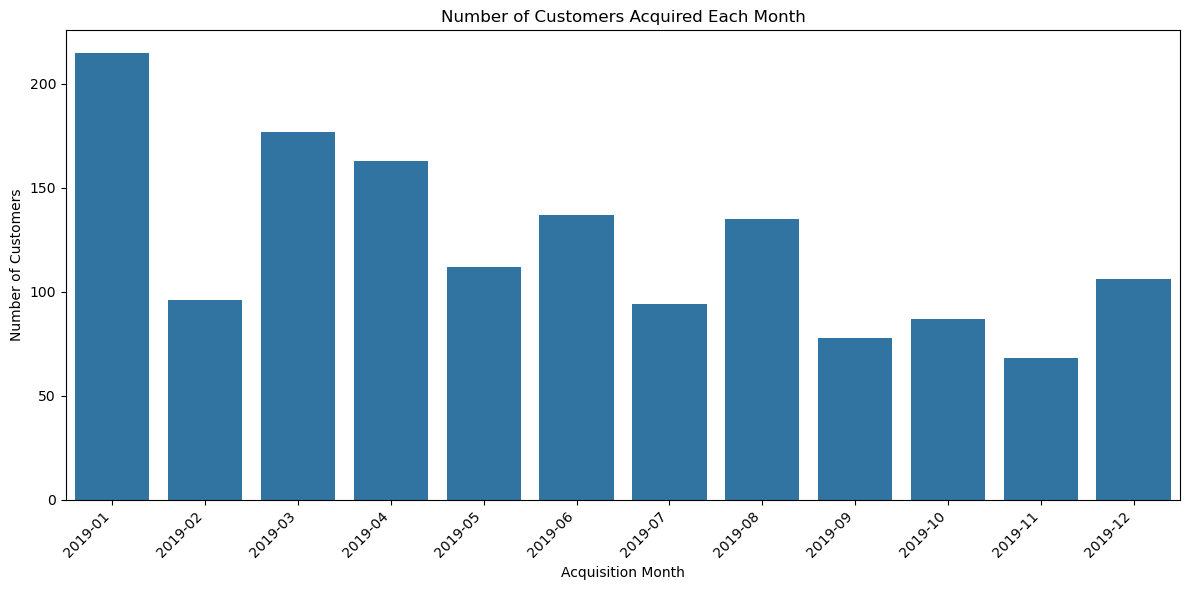

In [2792]:
# Plotting number of customers acquired each month
fig, ax = plt.subplots(figsize=(12, 6))
fig = sns.barplot(x= 'Acquisition_Month_Sales', y='count', data = acq_counts)

plt.title('Number of Customers Acquired Each Month')
plt.xlabel('Acquisition Month')
plt.ylabel('Number of Customers')


x_dates = acq_counts['Acquisition_Month_Sales'].dt.strftime('%Y-%m').sort_values()
plt.xticks(ticks = np.arange(len(acq_counts['Acquisition_Month_Sales'])), labels=x_dates, rotation=45, ha='right')


plt.tight_layout()
plt.show()

### 2.2 Revenue from existing/new customers

In [2793]:
# Classifying customer transations as new or existing in sales df based on acquisition month and transaction month
sales_v2 = sales_v2.merge(customer_v3[['CustomerID', 'Acquisition_Month_Sales']], how='left', on='CustomerID')
sales_v2['Customer_Type'] = np.where(sales_v2['Acquisition_Month_Sales'] == sales_v2['Month'], 'New', 'Existing')
sales_v2 = sales_v2.drop(columns='Acquisition_Month_Sales')
sales_v2.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Month,Discount_pct,GST,Sale_Amount,Customer_Type
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,2019-01,0.1,0.10,158.67,New
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,2019-01,0.1,0.10,158.67,New
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used,2019-01,0.1,0.10,8.53,New
3,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used,2019-01,0.1,0.18,24.02,New
4,17850,16682,2019-01-01,GGOEGBMJ013399,Sport Bag,Bags,15,5.15,6.5,Used,2019-01,0.1,0.18,88.54,New


In [2794]:
# Creating summary table for revenue from new vs existing customers on month on month basis (using unstack and stack method to retain zero values)
revenue_new_existing = sales_v2.groupby(['Month', 'Customer_Type'])['Sale_Amount'].sum().unstack(fill_value=0).stack().reset_index()
revenue_new_existing.rename(columns={0: 'Sale_Amount'}, inplace=True)
revenue_new_existing.head()

,Month,Customer_Type,Sale_Amount
0,2019-01,Existing,0.00
1,2019-01,New,493208.71
2,2019-02,Existing,46524.70
3,2019-02,New,327859.19
4,2019-03,Existing,66994.19


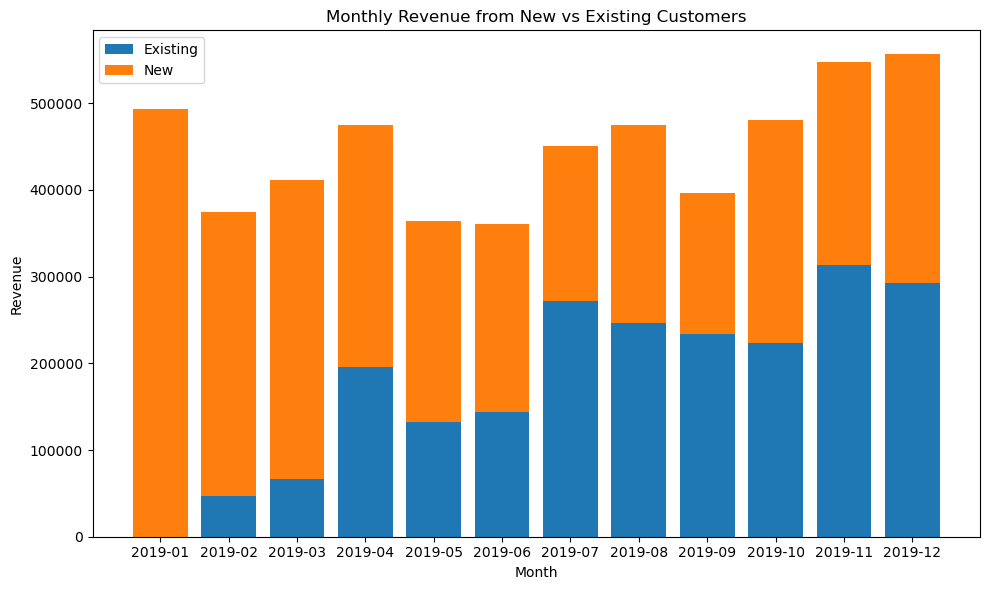

In [2795]:
# Visualizing revenue from new vs existing customers on month on month basis

months = revenue_new_existing['Month'].astype(str).unique()
new_sales = revenue_new_existing[revenue_new_existing['Customer_Type'] == 'New']['Sale_Amount'].reset_index(drop=True)
existing_sales = revenue_new_existing[revenue_new_existing['Customer_Type'] == 'Existing']['Sale_Amount'].reset_index(drop=True)    

plt.figure(figsize=(10, 6))
plt.bar(months, existing_sales, label='Existing')
plt.bar(months, new_sales, bottom=existing_sales, label='New')
plt.title('Monthly Revenue from New vs Existing Customers')
plt.xlabel('Month')
plt.ylabel('Revenue')
plt.legend()
plt.tight_layout()
plt.show()


### 2.3 Effect of discounts on revenue

In [2796]:
revenue_vs_discount = sales_v2.copy()

# Calculating discount, revenue and revenue excluding discount on a monthly basis
revenue_vs_discount['Discount_Amount'] = revenue_vs_discount['Quantity'] * revenue_vs_discount['Avg_Price'] * revenue_vs_discount['Discount_pct']
revenue_vs_discount_sum = revenue_vs_discount.groupby('Month').agg({'Sale_Amount': 'sum', 'Discount_Amount': 'sum'}).reset_index()
revenue_vs_discount_sum['Sale_Amount_Excl_Discount'] = revenue_vs_discount_sum['Sale_Amount'] + revenue_vs_discount_sum['Discount_Amount']
revenue_vs_discount_sum.head()

,Month,Sale_Amount,Discount_Amount,Sale_Amount_Excl_Discount
0,2019-01,493208.71,12971.820,506180.530
1,2019-02,374383.89,19423.334,393807.224
2,2019-03,411623.17,33966.564,445589.734
3,2019-04,475184.41,13440.403,488624.813
4,2019-05,364377.80,18889.306,383267.106


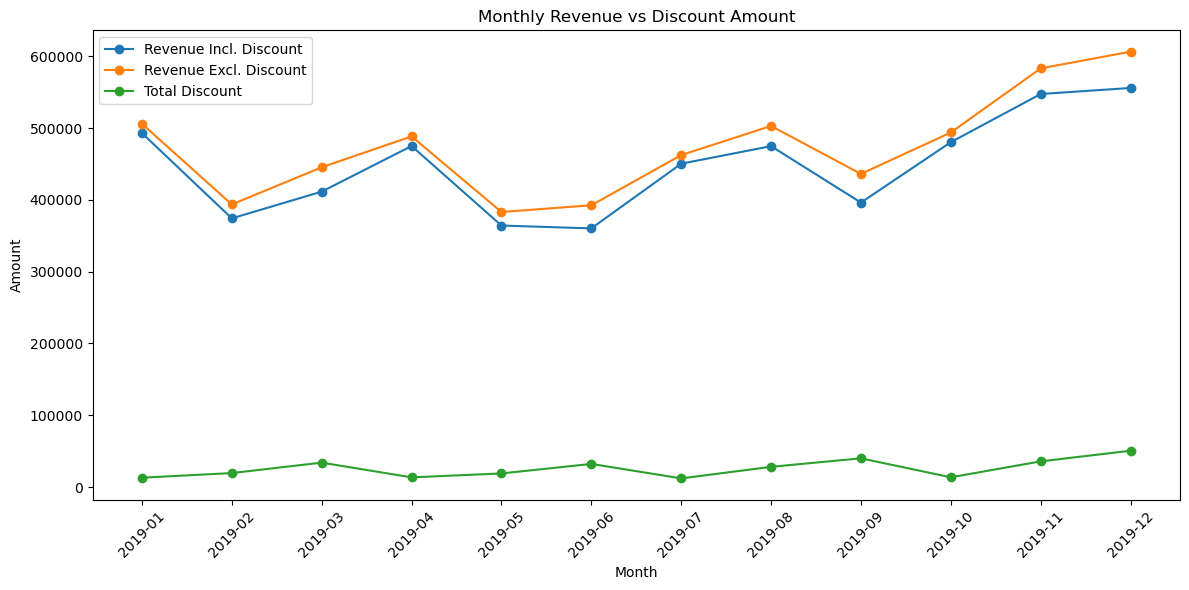

In [2797]:
# Line plot to visualize revenue vs discount amount on a monthly basis
plt.figure(figsize=(12, 6))
plt.plot(revenue_vs_discount_sum['Month'].astype(str), revenue_vs_discount_sum['Sale_Amount'], marker='o', label='Revenue Incl. Discount')
plt.plot(revenue_vs_discount_sum['Month'].astype(str), revenue_vs_discount_sum['Sale_Amount_Excl_Discount'], marker='o', label='Revenue Excl. Discount')
plt.plot(revenue_vs_discount_sum['Month'].astype(str), revenue_vs_discount_sum['Discount_Amount'], marker='o', label='Total Discount')
plt.title('Monthly Revenue vs Discount Amount')
plt.xlabel('Month')
plt.ylabel('Amount')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

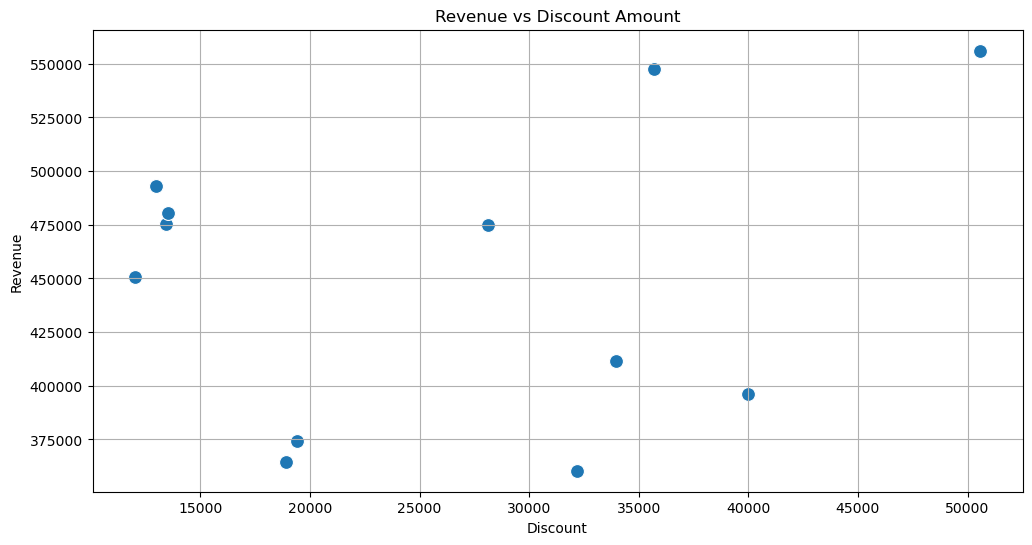

In [2798]:
# Scatter plot to visualize relationship between discount amount and revenue
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Discount_Amount', y='Sale_Amount', data=revenue_vs_discount_sum, s=100)
plt.title('Revenue vs Discount Amount')
plt.xlabel('Discount')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()

No indicator of correlation but very little data to draw any conclusions 

### 2.4 Effect of marketing spend on revenue

In [2799]:
marketing_vs_revenue = revenue_vs_discount_sum.copy()

marketing_vs_revenue = marketing_vs_revenue.merge(marketing.groupby('Month').agg({'Offline_Spend': 'sum', 'Online_Spend': 'sum'}).reset_index(), how='left', on='Month')
marketing_vs_revenue.head()

,Month,Sale_Amount,Discount_Amount,Sale_Amount_Excl_Discount,Offline_Spend,Online_Spend
0,2019-01,493208.71,12971.820,506180.530,97500,58328.95
1,2019-02,374383.89,19423.334,393807.224,82500,55658.80
2,2019-03,411623.17,33966.564,445589.734,73500,48750.09
3,2019-04,475184.41,13440.403,488624.813,96000,61026.83
4,2019-05,364377.80,18889.306,383267.106,67500,52759.64


In [2800]:
marketing_vs_revenue = marketing_vs_revenue.drop(columns=['Discount_Amount', 'Sale_Amount_Excl_Discount'])
marketing_vs_revenue['Total_Spend'] = marketing_vs_revenue['Offline_Spend'] + marketing_vs_revenue['Online_Spend']
marketing_vs_revenue.head()

,Month,Sale_Amount,Offline_Spend,Online_Spend,Total_Spend
0,2019-01,493208.71,97500,58328.95,155828.95
1,2019-02,374383.89,82500,55658.80,138158.80
2,2019-03,411623.17,73500,48750.09,122250.09
3,2019-04,475184.41,96000,61026.83,157026.83
4,2019-05,364377.80,67500,52759.64,120259.64


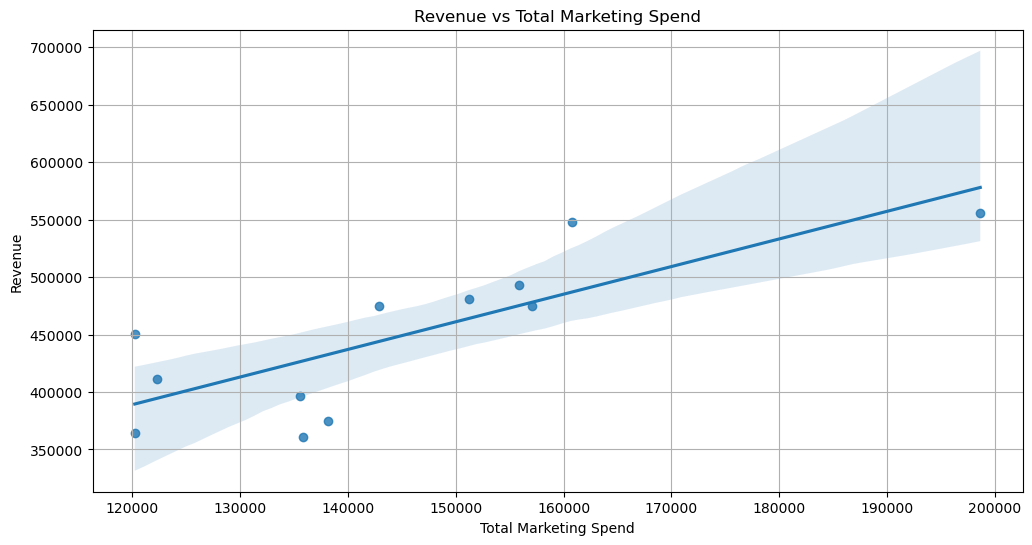

In [2801]:
plt.figure(figsize=(12, 6))
sns.regplot(x='Total_Spend', y='Sale_Amount', data=marketing_vs_revenue)
plt.title('Revenue vs Total Marketing Spend')
plt.xlabel('Total Marketing Spend')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()

In [2802]:
# Calculating correlation coefficients between marketing spend and revenue
total_marketing_vs_revenue = marketing_vs_revenue.copy()
total_marketing_vs_revenue.corr(method='pearson', numeric_only=True )

,Sale_Amount,Offline_Spend,Online_Spend,Total_Spend
Sale_Amount,1.000000,0.742049,0.814817,0.787263
Offline_Spend,0.742049,1.000000,0.884022,0.986812
Online_Spend,0.814817,0.884022,1.000000,0.948029
Total_Spend,0.787263,0.986812,0.948029,1.000000


In [2803]:
from statsmodels.formula.api import ols

mdl_spend_vs_revenue = ols('Sale_Amount ~ Total_Spend', data=marketing_vs_revenue).fit()
mdl_spend_vs_revenue.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Sale_Amount   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     16.30
Date:                Fri, 21 Nov 2025   Prob (F-statistic):            0.00237
Time:                        11:09:49   Log-Likelihood:                -144.16
No. Observations:                  12   AIC:                             292.3
Df Residuals:                      10   BIC:                             293.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1.007e+05   8.71e+04      1.155      0.275   -9.35e+04    2.95e+05
Total_Spend     2.4027      0.595      4.037      0.002       1.077       3.729
==============================================================================
Omnibus:                        0.440   Durbin-Watson:                   2.405
Prob(Omnibus):                  0.803   Jarque-Bera (JB):                0.497
Skew:                          -0.065   Prob(JB):                        0.780
Kurtosis:                       2.012   Cond. No.                     1.01e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.01e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

With a p-value of 0.002 and a R-squared of 0.62, there seems to be a relatively strong correlation between marketing spend and revenue. Based on the R-squared, the marketing spend explains 62% of the changes in revenue, with each additional dollar spent returning 2.4 dollar in revenue on average.

### 2.5 Top performing products

In [2804]:
# Creating a product dataframe with total sales amount and quantity sold per product
products = sales_v2.groupby('Product_Description').agg({'Sale_Amount': 'sum', 'Quantity': 'sum'}).reset_index()
products = products.sort_values('Sale_Amount', ascending=False).reset_index(drop=True)
products.head()

,Product_Description,Sale_Amount,Quantity
0,Nest Learning Thermostat 3rd Gen-USA - Stainle...,731870.78,4570
1,Nest Cam Outdoor Security Camera - USA,671619.74,5206
2,Nest Cam Indoor Security Camera - USA,567867.43,4402
3,Nest Protect Smoke + CO White Battery Alarm-USA,229032.98,2683
4,Nest Protect Smoke + CO White Wired Alarm-USA,225275.88,2670


In [2805]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Product_Description  404 non-null    object 
 1   Sale_Amount          404 non-null    float64
 2   Quantity             404 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 9.6+ KB


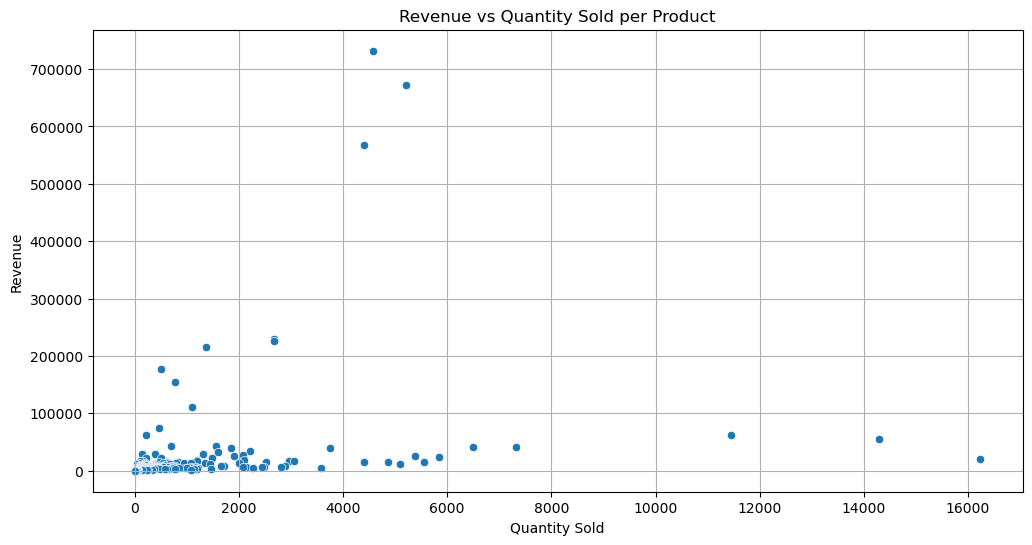

In [2806]:
# Looking at relationship between revenue and quantity sold per product
plt.figure(figsize=(12, 6))
sns.scatterplot(x='Quantity', y='Sale_Amount', data=products)
plt.title('Revenue vs Quantity Sold per Product')
plt.xlabel('Quantity Sold')
plt.ylabel('Revenue')
plt.grid(True)
plt.show()

In [2807]:
# Top performing products in terms of revenue
products[products['Sale_Amount'] > products['Sale_Amount'].quantile(0.99)]

,Product_Description,Sale_Amount,Quantity
0,Nest Learning Thermostat 3rd Gen-USA - Stainle...,731870.78,4570
1,Nest Cam Outdoor Security Camera - USA,671619.74,5206
2,Nest Cam Indoor Security Camera - USA,567867.43,4402
3,Nest Protect Smoke + CO White Battery Alarm-USA,229032.98,2683
4,Nest Protect Smoke + CO White Wired Alarm-USA,225275.88,2670


In [2808]:
# Top performing products in terms of quantity sold
products[products['Quantity'] > products['Quantity'].quantile(0.99)]

,Product_Description,Sale_Amount,Quantity
11,Google Sunglasses,62575.87,11452
12,Google 22 oz Water Bottle,55257.67,14282
15,Sport Bag,42068.43,7321
16,Google Metallic Notebook Set,41481.61,6496
31,Maze Pen,19786.11,16234


## 3 Customer segmentation

We will segment the customers by first doing a classical RFM analysis of the customers, and then using K-Means clustering on the RFM values to create customer segments. 

#### RFM Data preparation

**Definitions**

Recency (R) — How recently has a customer made a purchase?

$\begin{aligned}
R(in~days) = {End~Of~Observation~Window}{-}{Last~Purchase}
\end{aligned}$

<br/><br/> 

Frequency (F) — How often does a customer make purchases?

$\begin{aligned}
F(per~month) = \frac{Total~Transactions}{Transaction~Months}\
\end{aligned}$

<br/><br/> 

Monetary (M) — How much does a customer spend?

$\begin{aligned}
M(per~transaction) = \frac{Total~Sales}{Total~Transcations}\
\end{aligned}$

In [2868]:
# Set up a base dataframe for RFM analysis
rfm_data = customer_v3.copy()

In [2869]:
# Getting the necessary data from the sales dataset
rfm_data = rfm_data.merge(sales_v2.groupby('CustomerID').agg({'Transaction_ID': 'nunique', 'Sale_Amount': 'sum', 'Month': 'nunique', 'Transaction_Date': 'max'}).reset_index(), how='left', on='CustomerID')   
rfm_data.head()

,CustomerID,Gender,Location,Tenure_Months,Acquisition_Month_Sales,Transaction_ID,Sale_Amount,Month,Transaction_Date
0,17850,M,Chicago,12,2019-01,177,40489.84,1,2019-01-26
1,13047,M,California,43,2019-01,26,3348.80,3,2019-12-18
2,12583,M,Chicago,33,2019-01,15,3320.83,2,2019-08-02
3,13748,F,California,30,2019-01,1,7.96,1,2019-01-01
4,15100,M,California,49,2019-01,6,967.74,4,2019-08-30


In [2870]:
# Renameing columns for better clarity
rfm_data = rfm_data.rename(columns={'Transaction_ID': 'Total_Transactions', 'Sale_Amount': 'Total_Sales', 'Month': 'Transaction_Months', 'Transaction_Date': 'Last_Transaction_Date'})
rfm_data.head()

,CustomerID,Gender,Location,Tenure_Months,Acquisition_Month_Sales,Total_Transactions,Total_Sales,Transaction_Months,Last_Transaction_Date
0,17850,M,Chicago,12,2019-01,177,40489.84,1,2019-01-26
1,13047,M,California,43,2019-01,26,3348.80,3,2019-12-18
2,12583,M,Chicago,33,2019-01,15,3320.83,2,2019-08-02
3,13748,F,California,30,2019-01,1,7.96,1,2019-01-01
4,15100,M,California,49,2019-01,6,967.74,4,2019-08-30


In [2871]:
# Defining the RFM variables
rfm_data = rfm_data[['CustomerID', 'Total_Transactions', 'Total_Sales', 'Transaction_Months', 'Last_Transaction_Date']]
rfm_data['Recency'] = (pd.to_datetime('2019-12-31') - rfm_data['Last_Transaction_Date']).dt.days
rfm_data['Frequency'] = rfm_data['Total_Transactions'] / rfm_data['Transaction_Months']
rfm_data['Monetary'] = rfm_data['Total_Sales'] / rfm_data['Total_Transactions']
rfm_data = rfm_data[['CustomerID', 'Recency', 'Frequency', 'Monetary']]
rfm_data.head()

,CustomerID,Recency,Frequency,Monetary
0,17850,339,177.000000,228.756158
1,13047,13,8.666667,128.800000
2,12583,151,7.500000,221.388667
3,13748,364,1.000000,7.960000
4,15100,123,1.500000,161.290000


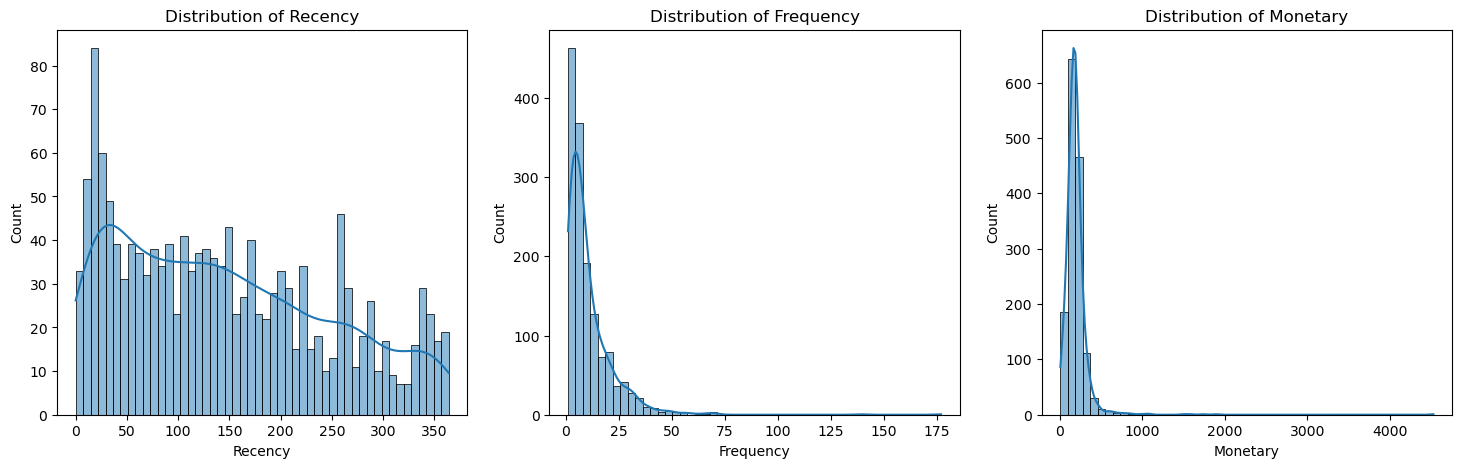

In [2872]:
# Checking distributions of Recency, Frequency and Monetary
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
sns.histplot(rfm_data['Recency'], bins=50, kde=True)
plt.title('Distribution of Recency')
plt.subplot(1, 3, 2)
sns.histplot(rfm_data['Frequency'], bins=50, kde=True)
plt.title('Distribution of Frequency')
plt.subplot(1, 3, 3)
sns.histplot(rfm_data['Monetary'], bins=50, kde=True)
plt.title('Distribution of Monetary')
plt.show()

In [2873]:
# Transforming Monetary and Frequency using log transformation to reduce skewness for K-Means clustering
rfm_data['Monetary'] = np.log1p(rfm_data['Monetary'])
rfm_data['Frequency'] = np.log1p(rfm_data['Frequency'])

In [2874]:
# Normalizing RFM values using Min-Max Scaling for K-Means clustering
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

rfm_scaled = rfm_data.copy()
rfm_scaled[['Recency', 'Frequency', 'Monetary']] = scaler.fit_transform(rfm_scaled[['Recency', 'Frequency', 'Monetary']])
rfm_scaled.head()



,CustomerID,Recency,Frequency,Monetary
0,17850,0.931319,1.000000,0.529736
1,13047,0.035714,0.351006,0.439677
2,12583,0.414835,0.322352,0.524596
3,13748,1.000000,0.000000,0.018071
4,15100,0.337912,0.049713,0.474909


#### K-Means

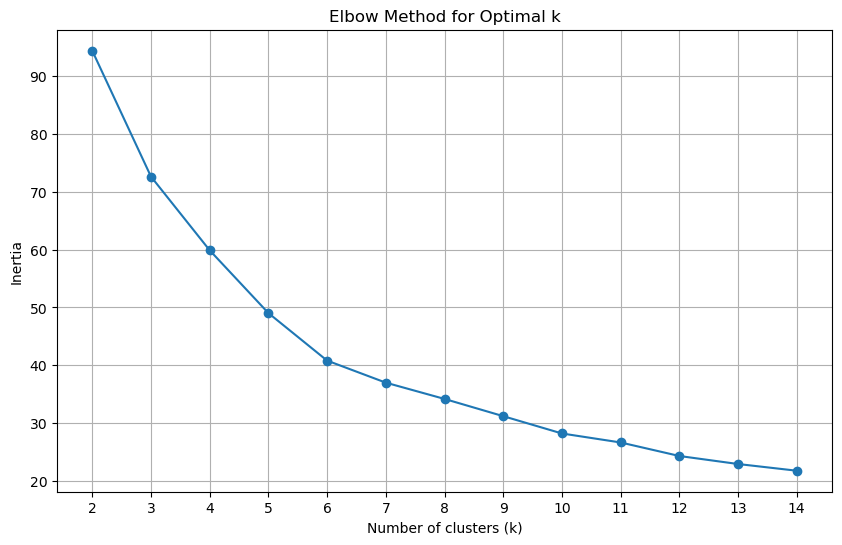

In [2875]:
# Plotting the elbow curve to determine optimal number of clusters
from sklearn.cluster import KMeans

inertia = []
K_range = range(2, 15)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled[['Recency', 'Frequency', 'Monetary']])
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.xticks(K_range)
plt.grid(True)
plt.show()

The elbow seems to be at 6 clusters.

In [2876]:
kmeans = KMeans(n_clusters=6, random_state=42)
rfm_scaled['KMeans_Cluster'] = kmeans.fit_predict(rfm_scaled[['Recency', 'Frequency', 'Monetary']])
rfm_scaled.head()

,CustomerID,Recency,Frequency,Monetary,KMeans_Cluster
0,17850,0.931319,1.000000,0.529736,2
1,13047,0.035714,0.351006,0.439677,1
2,12583,0.414835,0.322352,0.524596,0
3,13748,1.000000,0.000000,0.018071,5
4,15100,0.337912,0.049713,0.474909,3


In [2877]:
# Inverting recency, monetary and frequency back to original scale for better interpretability
rfm_final = rfm_scaled.copy()
rfm_final[['Recency', 'Frequency', 'Monetary']] = scaler.inverse_transform(rfm_final[['Recency', 'Frequency', 'Monetary']])
rfm_final['Frequency'] = np.expm1(rfm_final['Frequency'])
rfm_final['Monetary'] = np.expm1(rfm_final['Monetary'])
rfm_final.head()

,CustomerID,Recency,Frequency,Monetary,KMeans_Cluster
0,17850,339.0,177.000000,228.756158,2
1,13047,13.0,8.666667,128.800000,1
2,12583,151.0,7.500000,221.388667,0
3,13748,364.0,1.000000,7.960000,5
4,15100,123.0,1.500000,161.290000,3


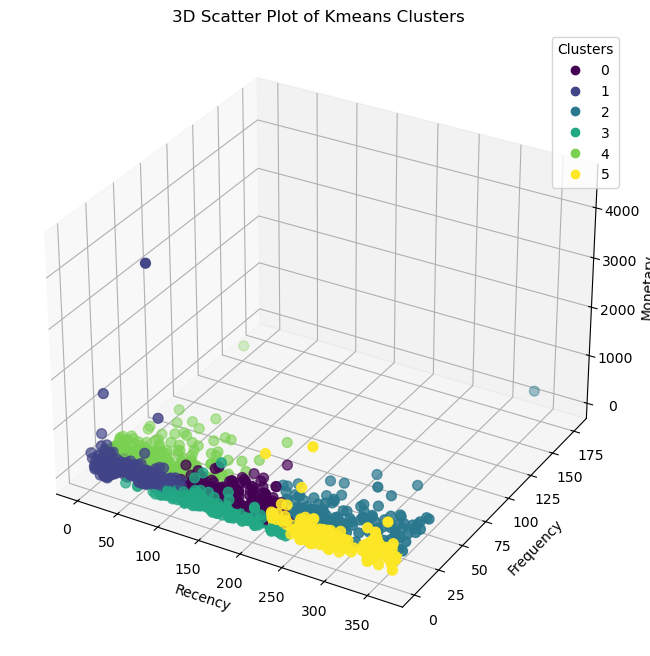

In [2878]:
# Plotting 3D scatter plot of KMeans Clusters
from mpl_toolkits.mplot3d import Axes3D

colors = rfm_final['KMeans_Cluster']

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
k_means_scatter = ax.scatter(rfm_final['Recency'], rfm_final['Frequency'], rfm_final['Monetary'], c=colors, cmap='viridis', s=50)

ax.set_title('3D Scatter Plot of Kmeans Clusters')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

ax.legend(*k_means_scatter.legend_elements(), title='Clusters')

plt.show()

In [2879]:
# Looking at cluster characteristics
rfm_final.groupby('KMeans_Cluster').agg({'CustomerID': 'nunique', 'Monetary': 'mean', 'Frequency': 'mean', 'Recency': 'mean'}).sort_values('Recency').reset_index()

,KMeans_Cluster,CustomerID,Monetary,Frequency,Recency
0,1,350,221.191925,5.334878,44.585714
1,4,274,207.665515,21.914860,55.605839
2,3,179,118.630240,1.994413,152.631285
3,0,318,181.914988,10.278145,165.342767
4,2,160,204.791197,21.892708,288.643750
5,5,187,214.368663,3.466132,293.566845


#### Cluster characteristics

The three clusters seem to have the following characteristics:

0: Purchases moderately often with average spend. Have not purchased in a while.
<br>
<br>
1: Purchases rarely with a high spend. Have made recent purchases.
<br>
<br> 
2: Purchases often with high spend. Have not made a purchase in a long time.
<br>
<br>
3: Purchases very rarely with low spend. Have not made a purchase a while.
<br>
<br>
4: Purchases very frequently with a high spend. Have made recent purchases.
<br>
<br>
5: Purchases rarely with a high spend. Have not made a purchase in a long time.


#### Strategy

In order to develop strategies for clusters, we could first divide them based on recency into Loyal, At risk and Churned Customers:

**Loyal Customers**
<br>
1: Efforts could be made to try to increase frequency, by e.g. introducing more products that meet more of their needs.
<br>
4: With both high frequency and average spend, these are the highest value customers. Efforts to nurture loyalty within this segment should be prioritised, eg. through offering generous discounts.

**At Risk Customers**
<br>
3: These are very low value customers, with both low frequency and average spend. Resources should be prioritised elsewhere.
<br>
0: Churn mitigation strategies should be employed, eg. through email campaigns offering discounts etc.

**Churned Customers**
<br>
2: These are previous high value customers, and win-back strategies should be focused on these as they represent a lot of lost revenue for the company.
<br>
5: Even though these customers had high average spend, with such low frequency they do not represent a big loss to the company. Win-back resources should be focused on the previous customers instead.





## 4 Predictive CLV Classification

For this part, we will first calculate the predicted one year LTV for the customers, then group them into CLV classes and then build a classification model to predict customer CLV class based on the customers' first month of activity with the company. This will enable the fast feedback in terms of customer acquisition in terms of the value of new customers, which can be used to optimise acquisition efforts. 

#### Customer Lifetime Value (CLV)

In order to determine the 1 year CLV for customers we will utilize the BG/NBD and Gamma-Gamma models.

* BG/NBD → Predicts the expected number of transactions
* Gamma-Gamma → Predicts the expected profit per transaction
* CLTV → Calculated as the product of these two predictions to estimate individual customer lifetime value


Let's start with constructing RFM variables for all customers. The BG/NBD + Gamma-Gamma model uses slightly different RFM variables then we used previously for the K-means clustering:

* Frequency: Number of repeat time periods the customer had a purchase in
* Recency: Time periods between first and last purchase
* T: Time periods between first purchase and end of observation period
* Monetary: Average monetary value per purchase

<br>

We will use weeks as the time-period to get a good balance between granularity and stability.

In [1796]:
last_date = sales_v2['Transaction_Date'].max()
current_date = last_date + pd.Timedelta(weeks=4)

clv_pred = sales_v2.groupby('CustomerID').agg({'Sale_Amount': 'sum', 
                                               'Transaction_ID': 'nunique', 
                                               'Transaction_Date': [lambda x: (current_date - x.min()).days]})

clv_pred.columns = ['Monetary', 'Frequency', 'T']

clv_pred['Monetary'] = clv_pred['Monetary'] / clv_pred['Frequency'] # Average monetary value per purchase
clv_pred['T'] = (clv_pred['T'] / 7).round(2) # Converting days to weeks

clv_pred.head()

,Monetary,Frequency,T
CustomerID,,,
12346,174.980000,1,19.29
12347,506.026774,31,44.29
12348,211.192500,8,31.43
12350,133.404545,11,6.43
12356,154.414615,13,19.29


In [1797]:
# create a 'week' period column (ISO week starting Monday)
sales_v2['Week'] = sales_v2['Transaction_Date'].dt.to_period('W').apply(lambda r: r.start_time)

# count distinct weeks with purchase per customer
weeks_with_purchase = sales_v2.groupby('CustomerID')['Week'].nunique().rename('Weeks_with_purchase')

# Change frequency to repeat number of weeks with purchase
clv_pred = clv_pred.merge(weeks_with_purchase, how='left', on='CustomerID')
clv_pred['Frequency'] = clv_pred['Weeks_with_purchase'] - 1

# first and last purchase week per customer
first_week = sales_v2.groupby('CustomerID')['Week'].min()
last_week = sales_v2.groupby('CustomerID')['Week'].max()

# recency in weeks = number of weeks between first and last purchase week
clv_pred['Recency'] = ((last_week - first_week).dt.days / 7).clip(lower=0)

clv_pred = clv_pred.drop(columns=['Weeks_with_purchase'])
clv_pred.head()

,Monetary,Frequency,T,Recency
CustomerID,,,,
12346,174.980000,0,19.29,0.0
12347,506.026774,1,44.29,32.0
12348,211.192500,1,31.43,17.0
12350,133.404545,0,6.43,0.0
12356,154.414615,0,19.29,0.0


In [1798]:
clv_pred.describe()

,Monetary,Frequency,T,Recency
count,1468.000000,1468.000000,1468.000000,1468.000000
mean,194.996482,0.921662,33.807425,9.192779
std,172.274590,1.765764,14.953885,13.904986
min,6.990000,0.000000,4.000000,0.000000
25%,132.328214,0.000000,22.290000,0.000000
50%,178.226502,0.000000,35.710000,0.000000
75%,222.200446,1.000000,46.035000,17.000000
max,4530.265000,20.000000,56.000000,51.000000


In [1799]:
# Tuning the penalizer coefficient for BG/NBD model

from lifetimes import BetaGeoFitter
from sklearn.metrics import mean_squared_error
import numpy as np

penalizers = [0.001, 0.01, 0.1, 1]
results = []


for p in penalizers:
    bgf = BetaGeoFitter(penalizer_coef=p)
    bgf.fit(clv_pred['Frequency'],
            clv_pred['Recency'],
            clv_pred['T'])
    
    # Predict expected number of transactions in the observed period
    predicted_purchases = bgf.conditional_expected_number_of_purchases_up_to_time(
        clv_pred['T'],
        clv_pred['Frequency'],
        clv_pred['Recency'],
        clv_pred['T']
    )
    
    rmse = np.sqrt(mean_squared_error(clv_pred['Frequency'], predicted_purchases))
    loglike = bgf._negative_log_likelihood_ * -1  # For readability
    
    results.append({'Penalizer': p, 'RMSE': rmse, 'LogLikelihood': loglike})

results_df = pd.DataFrame(results)
print(results_df.sort_values('RMSE'))

   Penalizer      RMSE  LogLikelihood
3      1.000  0.511617      -0.497061
2      0.100  0.635334      -0.394482
1      0.010  0.773527      -0.358362
0      0.001  0.888342      -0.350181


The RMSE is highest with the lowest penalizer so we will continue with that one.

In [1800]:
# Creating BG/NBD Model

bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(clv_pred['Frequency'],
        clv_pred['Recency'],
        clv_pred['T'])

# Predicting number of purchases in next 12 months for all customers

clv_pred['Predicted_Purchases_12_Months'] = bgf.conditional_expected_number_of_purchases_up_to_time(52,
                                                                                                   clv_pred['Frequency'],
                                                                                                   clv_pred['Recency'],
                                                                                                   clv_pred['T'])


clv_pred.head()

,Monetary,Frequency,T,Recency,Predicted_Purchases_12_Months
CustomerID,,,,,
12346,174.980000,0,19.29,0.0,0.740365
12347,506.026774,1,44.29,32.0,0.879084
12348,211.192500,1,31.43,17.0,1.016308
12350,133.404545,0,6.43,0.0,1.025077
12356,154.414615,0,19.29,0.0,0.740365


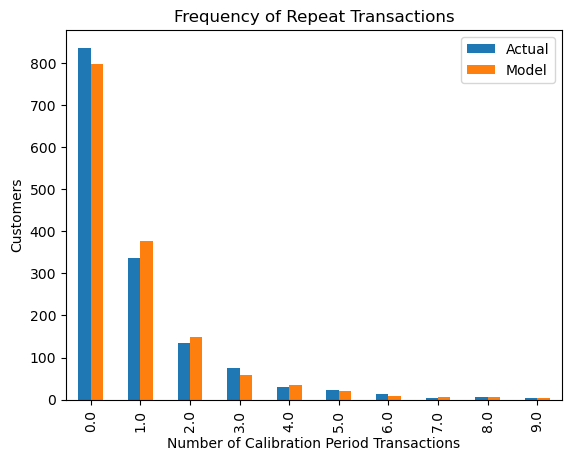

In [1801]:
from lifetimes.plotting import plot_period_transactions 

_ = plot_period_transactions(bgf, max_frequency=10)

The number of repeat transactions in the model and in the actual dataset is quite well matched so the model seems sound.

In [1802]:
# Checking correlation between Monetary and Frequency as Gamma-Gamma model assumes independence between these two variables
clv_pred[['Monetary', 'Frequency']].corr()

,Monetary,Frequency
Monetary,1.000000,0.012249
Frequency,0.012249,1.000000


In [1803]:
# Filtering to only repeat customers for Gamma Gamma model
clv_filtered = clv_pred[clv_pred['Frequency'] > 0]


In [1804]:
# Creating Gamma-Gamma Model

from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef=0.001)
ggf.fit(clv_filtered['Frequency'], clv_filtered['Monetary'])

clv_pred['Expected_Average_Profit'] = ggf.conditional_expected_average_profit(clv_pred['Frequency'], clv_pred['Monetary'])
clv_pred.head()

,Monetary,Frequency,T,Recency,Predicted_Purchases_12_Months,Expected_Average_Profit
CustomerID,,,,,,
12346,174.980000,0,19.29,0.0,0.740365,395.474749
12347,506.026774,1,44.29,32.0,0.879084,502.497092
12348,211.192500,1,31.43,17.0,1.016308,217.076225
12350,133.404545,0,6.43,0.0,1.025077,395.474749
12356,154.414615,0,19.29,0.0,0.740365,395.474749


In [1805]:
# Estimating one year CLV for all customers
clv_final = ggf.customer_lifetime_value(bgf,
                                       clv_pred['Frequency'],
                                       clv_pred['Recency'],
                                       clv_pred['T'],
                                       clv_pred['Monetary'],
                                       time=52,
                                       freq='W',
                                       discount_rate=0.002) # 0.2% Weekly discount rate ~ 10% annually

clv_final = clv_final.reset_index()

clv_final = clv_pred.merge(clv_final, how='left', on='CustomerID')
clv_final.sort_values('clv', ascending=False).head(10)


,CustomerID,Monetary,Frequency,T,Recency,Predicted_Purchases_12_Months,Expected_Average_Profit,clv
736,15311,298.630722,19,55.86,50.0,11.593747,298.798535,12616.990444
447,14180,579.701951,9,52.86,47.0,5.908514,579.029310,12405.220268
643,14911,211.197826,20,54.57,49.0,12.395958,211.501206,9539.316394
563,14606,228.234048,16,53.86,50.0,10.282800,228.578073,8543.293872
1355,17841,210.525095,15,54.57,48.0,9.325299,210.930855,7152.924954
202,13089,173.484602,17,50.29,44.0,11.048359,173.914440,6963.192210
703,15194,430.482000,6,45.43,38.0,4.374295,430.290624,6767.075187
254,13267,682.055769,5,43.86,21.0,2.702308,680.177822,6591.822101
214,13113,742.392414,3,42.71,38.0,2.451578,738.620013,6464.853283
389,13929,1576.055000,1,19.57,3.0,1.142530,1538.361680,6028.236476


In [1806]:
# Checking CLV information
clv_final['clv'].describe()

count     1468.000000
mean       998.470974
std        834.185667
min        111.739505
25%        640.326634
50%        830.817012
75%       1130.595747
max      12616.990444
Name: clv, dtype: float64

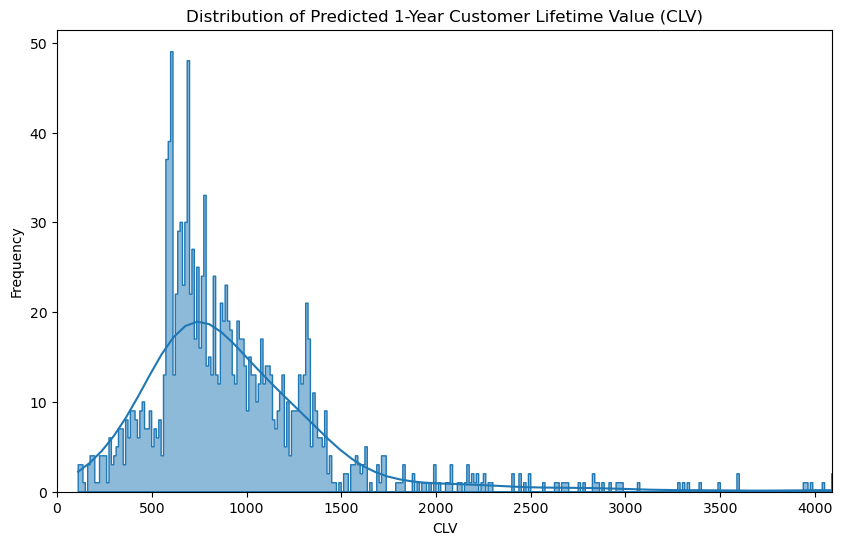

In [ ]:
# Plotting distributution of predicted CLV
fig = plt.figure(figsize=(10,6))
sns.histplot(clv_final, x='clv', bins=1000, element='step', kde=True)
plt.title('Distribution of Predicted 1-Year Customer Lifetime Value (CLV)')
plt.xlabel('CLV')
plt.ylabel('Frequency')
plt.xlim(0, clv_final['clv'].quantile(0.99))  # Limiting x-axis for better visualization
plt.show()

In order to group the customers into distinct CLV classes, we will use GMM to cluster the customers based on the CLV.

In [ ]:
# Using BIC to determine optimal number of GMM clusters
from sklearn.mixture import GaussianMixture

# log-transform CLV values to reduce skew
X = np.log1p(clv_final['clv'].values.reshape(-1, 1))

for k in range(1,6):
    gmmk = GaussianMixture(n_components=k, random_state=42).fit(X)
    print(k, gmmk.bic(X))


1 2314.18591066141
2 2111.3855786764993
3 2137.395633256163
4 2108.100007479514
5 2114.2412694757827


The BIC is lowest at 4 clusters so we will proceed with 4.

In [1809]:
# Segmenting customers based on CLV using Gaussian Mixture Model
gmm = GaussianMixture(n_components=4, random_state=42)
gmm.fit(X)

clv_final['CLV_Segment_GM'] = gmm.predict(X)

In [1810]:
# Turning segment numbers into labels
segment_order = clv_final.groupby('CLV_Segment_GM')['clv'].mean().sort_values().index
segment_labels = {segment_order[0]:'Low', segment_order[1]:'Medium', segment_order[2]:'High', segment_order[3]:'Premium'}
clv_final['CLV_Segment_GM'] = clv_final['CLV_Segment_GM'].map(segment_labels)

In [1811]:
# Customer CLV segments based on Gaussian Mixture Model
clv_final.groupby('CLV_Segment_GM').agg({'count', 'mean', 'min', 'max'})['clv']

,count,mean,min,max
CLV_Segment_GM,,,,
High,554,1168.027339,893.541728,1735.429187
Low,141,342.331178,111.739505,475.441306
Medium,683,695.882597,478.282602,891.328969
Premium,90,3279.019261,1795.336971,12616.990444


### Feature engineering

Let's compile some data from new customers to use as potential features in the model.

* Total Sales
* Transaction Frequency
* Transaction Day Frequency
* Average Days Between Transactions
* Average Basket Value
* Total Quantity
* Average Basket Item Value
* Product Category Quantity Share
* Top Product Category
* Product Category Entropy
* Sales within Top Products
* Total Discount Amount
* Discount/Sales Ratio
* Total Delivery Charges
* Delivery Charge / Sales Ratio
* Recency
* Recency Ratio
* Days to first repeat purchase
* Days to first repeat purchase ratio  
* Gender - might have an indirect impact if certain segments are overrepresented within specific genders
* Location - might have an indirect impact if certain segments are overepresented in specific locations



In [2059]:
# Making sure we only include customers who have more than 30 days of potential sales data
cutoff_date = sales_v2['Transaction_Date'].max() - pd.Timedelta(days=30)
valid_customers = sales_v2.loc[sales_v2['Transaction_Date'] <= cutoff_date, 'CustomerID'].unique()
sales_v2_filtered = sales_v2[sales_v2['CustomerID'].isin(valid_customers)]
sales_v2_filtered.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Month,Discount_pct,GST,Sale_Amount,Cohort_Month,Customer_Type,Days_Since_First_Transaction,Discount_Amount,week,Week
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,2019-01,0.1,0.10,158.67,2019-01,New,0,15.371,2018-12-31,2018-12-31
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,2019-01,0.1,0.10,158.67,2019-01,New,0,15.371,2018-12-31,2018-12-31
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used,2019-01,0.1,0.10,8.53,2019-01,New,0,0.205,2018-12-31,2018-12-31
3,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used,2019-01,0.1,0.18,24.02,2019-01,New,0,1.650,2018-12-31,2018-12-31
4,17850,16682,2019-01-01,GGOEGBMJ013399,Sport Bag,Bags,15,5.15,6.5,Used,2019-01,0.1,0.18,88.54,2019-01,New,0,7.725,2018-12-31,2018-12-31


In [2060]:
# Creating a dataframe to include the sales from the first 30 days for each customer
sales_v2_filtered['Days_Since_First_Transaction'] = (
    sales_v2_filtered['Transaction_Date'] - 
    sales_v2_filtered.groupby('CustomerID')['Transaction_Date'].transform('min')).dt.days

first_month_sales = sales_v2_filtered[sales_v2_filtered['Days_Since_First_Transaction'] <= 30]
first_month_sales.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Month,Discount_pct,GST,Sale_Amount,Cohort_Month,Customer_Type,Days_Since_First_Transaction,Discount_Amount,week,Week
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,2019-01,0.1,0.10,158.67,2019-01,New,0,15.371,2018-12-31,2018-12-31
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,2019-01,0.1,0.10,158.67,2019-01,New,0,15.371,2018-12-31,2018-12-31
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used,2019-01,0.1,0.10,8.53,2019-01,New,0,0.205,2018-12-31,2018-12-31
3,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used,2019-01,0.1,0.18,24.02,2019-01,New,0,1.650,2018-12-31,2018-12-31
4,17850,16682,2019-01-01,GGOEGBMJ013399,Sport Bag,Bags,15,5.15,6.5,Used,2019-01,0.1,0.18,88.54,2019-01,New,0,7.725,2018-12-31,2018-12-31


In [2061]:
# Creating base dataframe of customer ids for random forest features
rf_df = pd.DataFrame(first_month_sales['CustomerID'].unique())
rf_df = rf_df.rename(columns={0: 'CustomerID'})
rf_df.head()

,CustomerID
0,17850
1,13047
2,12583
3,15291
4,14688


##### Sale amount

In [2062]:
# Creating a dataframe to include the sales from the first 30 days for each customer

sales_amount = (
    first_month_sales
    .groupby('CustomerID')
    .agg({'Sale_Amount': 'sum'})
    .reset_index()
)


rf_df = rf_df.merge(sales_amount, how='left', on='CustomerID')
rf_df.head()

,CustomerID,Sale_Amount
0,17850,40489.84
1,13047,1090.10
2,12583,1538.00
3,15291,102.67
4,14688,2584.52


##### Transaction Frequency

In [2063]:
# Frequency of transactions
trans_freq = (
    first_month_sales
    .groupby('CustomerID')
    .agg({'Transaction_ID': 'nunique'})
    .reset_index()
)

trans_freq.rename(columns={'Transaction_ID': 'Transaction_Frequency'}, inplace=True)

rf_df = rf_df.merge(trans_freq, how='left', on='CustomerID')
rf_df.head()

,CustomerID,Sale_Amount,Transaction_Frequency
0,17850,40489.84,177
1,13047,1090.10,6
2,12583,1538.00,5
3,15291,102.67,1
4,14688,2584.52,13


##### Day Frequency

In [2064]:
# Frequency of purchases in first 30 days
days_freq = (
    first_month_sales
    .groupby('CustomerID')
    .agg({'Transaction_Date': 'nunique'})
    .reset_index()
)

days_freq.rename(columns={'Transaction_Date': 'Day_Frequency'}, inplace=True)

rf_df = rf_df.merge(days_freq, how='left', on='CustomerID')
rf_df.head()

,CustomerID,Sale_Amount,Transaction_Frequency,Day_Frequency
0,17850,40489.84,177,10
1,13047,1090.10,6,1
2,12583,1538.00,5,1
3,15291,102.67,1,1
4,14688,2584.52,13,2


##### Average days between purchase days

In [2065]:
rf_df['Avg_Days_Between_Purchases'] = 30 / rf_df['Day_Frequency']
rf_df.head()

,CustomerID,Sale_Amount,Transaction_Frequency,Day_Frequency,Avg_Days_Between_Purchases
0,17850,40489.84,177,10,3.0
1,13047,1090.10,6,1,30.0
2,12583,1538.00,5,1,30.0
3,15291,102.67,1,1,30.0
4,14688,2584.52,13,2,15.0


##### Average basket value

In [2066]:
rf_df['Average_Basket_Value'] = rf_df['Sale_Amount'] / rf_df['Transaction_Frequency']
rf_df.head()

,CustomerID,Sale_Amount,Transaction_Frequency,Day_Frequency,Avg_Days_Between_Purchases,Average_Basket_Value
0,17850,40489.84,177,10,3.0,228.756158
1,13047,1090.10,6,1,30.0,181.683333
2,12583,1538.00,5,1,30.0,307.600000
3,15291,102.67,1,1,30.0,102.670000
4,14688,2584.52,13,2,15.0,198.809231


##### Total Quantity

In [2067]:
# First 30 days quantity 

first_30_days_quantity = (
    first_month_sales
    .groupby('CustomerID')
    .agg({'Quantity': 'sum'})
    .reset_index()
)

rf_df = rf_df.merge(first_30_days_quantity, how='left', on='CustomerID')
rf_df.head()

,CustomerID,Sale_Amount,Transaction_Frequency,Day_Frequency,Avg_Days_Between_Purchases,Average_Basket_Value,Quantity
0,17850,40489.84,177,10,3.0,228.756158,1133
1,13047,1090.10,6,1,30.0,181.683333,137
2,12583,1538.00,5,1,30.0,307.600000,72
3,15291,102.67,1,1,30.0,102.670000,2
4,14688,2584.52,13,2,15.0,198.809231,56


##### Average basket item value

In [2068]:
rf_df['Avg_Item_Value'] = rf_df['Sale_Amount'] / rf_df['Quantity']
rf_df.head()

,CustomerID,Sale_Amount,Transaction_Frequency,Day_Frequency,Avg_Days_Between_Purchases,Average_Basket_Value,Quantity,Avg_Item_Value
0,17850,40489.84,177,10,3.0,228.756158,1133,35.736840
1,13047,1090.10,6,1,30.0,181.683333,137,7.956934
2,12583,1538.00,5,1,30.0,307.600000,72,21.361111
3,15291,102.67,1,1,30.0,102.670000,2,51.335000
4,14688,2584.52,13,2,15.0,198.809231,56,46.152143


##### Product category quantity

In [2069]:
# Quantity per product category
category_qty = (
    first_month_sales
    .groupby(['CustomerID', 'Product_Category'])['Quantity']
    .sum()
    .unstack(fill_value=0)
)

# Normalize to shares
category_qty = category_qty.div(category_qty.sum(axis=1), axis=0).fillna(0)

# Merge to feature set
rf_df = rf_df.merge(category_qty, how='left', on='CustomerID')
rf_df.head()

,CustomerID,Sale_Amount,Transaction_Frequency,Day_Frequency,Avg_Days_Between_Purchases,Average_Basket_Value,Quantity,Avg_Item_Value,Accessories,Android,...,Headgear,Housewares,Lifestyle,More Bags,Nest,Nest-Canada,Nest-USA,Notebooks & Journals,Office,Waze
0,17850,40489.84,177,10,3.0,228.756158,1133,35.736840,0.0,0.0,...,0.014122,0.013239,0.150927,0.0,0.0,0.006178,0.159753,0.000883,0.372462,0.008826
1,13047,1090.10,6,1,30.0,181.683333,137,7.956934,0.0,0.0,...,0.000000,0.000000,0.007299,0.0,0.0,0.000000,0.036496,0.000000,0.897810,0.000000
2,12583,1538.00,5,1,30.0,307.600000,72,21.361111,0.0,0.0,...,0.013889,0.000000,0.013889,0.0,0.0,0.000000,0.013889,0.361111,0.055556,0.000000
3,15291,102.67,1,1,30.0,102.670000,2,51.335000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,14688,2584.52,13,2,15.0,198.809231,56,46.152143,0.0,0.0,...,0.107143,0.000000,0.035714,0.0,0.0,0.142857,0.107143,0.000000,0.571429,0.000000


##### Top Product category

In [2070]:
cat_cols = category_qty.columns
rf_df['Top_Category'] = rf_df[cat_cols].idxmax(axis=1)

rf_df.head()

,CustomerID,Sale_Amount,Transaction_Frequency,Day_Frequency,Avg_Days_Between_Purchases,Average_Basket_Value,Quantity,Avg_Item_Value,Accessories,Android,...,Housewares,Lifestyle,More Bags,Nest,Nest-Canada,Nest-USA,Notebooks & Journals,Office,Waze,Top_Category
0,17850,40489.84,177,10,3.0,228.756158,1133,35.736840,0.0,0.0,...,0.013239,0.150927,0.0,0.0,0.006178,0.159753,0.000883,0.372462,0.008826,Office
1,13047,1090.10,6,1,30.0,181.683333,137,7.956934,0.0,0.0,...,0.000000,0.007299,0.0,0.0,0.000000,0.036496,0.000000,0.897810,0.000000,Office
2,12583,1538.00,5,1,30.0,307.600000,72,21.361111,0.0,0.0,...,0.000000,0.013889,0.0,0.0,0.000000,0.013889,0.361111,0.055556,0.000000,Drinkware
3,15291,102.67,1,1,30.0,102.670000,2,51.335000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,Apparel
4,14688,2584.52,13,2,15.0,198.809231,56,46.152143,0.0,0.0,...,0.000000,0.035714,0.0,0.0,0.142857,0.107143,0.000000,0.571429,0.000000,Office


##### Product category entropy

In [2071]:

p = category_qty.replace(0, np.nan)
category_entropy = -(p * np.log(p)).sum(axis=1).fillna(0)

n_categories = category_qty.shape[1]
category_entropy_norm = category_entropy / np.log(n_categories)

entropy_df = pd.DataFrame({
    'CustomerID': category_qty.index,
    'Category_Entropy_Norm': category_entropy_norm
}).reset_index(drop=True)

rf_df = rf_df.merge(entropy_df, how='left', on='CustomerID')
rf_df.head()

,CustomerID,Sale_Amount,Transaction_Frequency,Day_Frequency,Avg_Days_Between_Purchases,Average_Basket_Value,Quantity,Avg_Item_Value,Accessories,Android,...,Lifestyle,More Bags,Nest,Nest-Canada,Nest-USA,Notebooks & Journals,Office,Waze,Top_Category,Category_Entropy_Norm
0,17850,40489.84,177,10,3.0,228.756158,1133,35.736840,0.0,0.0,...,0.150927,0.0,0.0,0.006178,0.159753,0.000883,0.372462,0.008826,Office,0.611840
1,13047,1090.10,6,1,30.0,181.683333,137,7.956934,0.0,0.0,...,0.007299,0.0,0.0,0.000000,0.036496,0.000000,0.897810,0.000000,Office,0.147339
2,12583,1538.00,5,1,30.0,307.600000,72,21.361111,0.0,0.0,...,0.013889,0.0,0.0,0.000000,0.013889,0.361111,0.055556,0.000000,Drinkware,0.489612
3,15291,102.67,1,1,30.0,102.670000,2,51.335000,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,Apparel,-0.000000
4,14688,2584.52,13,2,15.0,198.809231,56,46.152143,0.0,0.0,...,0.035714,0.0,0.0,0.142857,0.107143,0.000000,0.571429,0.000000,Office,0.447024


##### Top products sales

In [2072]:
# Top 30 products by revenue
top_products = sales_v2.groupby('Product_SKU')['Sale_Amount'].sum().sort_values(ascending=False).head(30).index

# Pivot to get revenue share per customer
customer_product_features = (
    first_month_sales[first_month_sales['Product_SKU'].isin(top_products)]
    .groupby(['CustomerID', 'Product_SKU'])['Sale_Amount'].sum()
    .unstack(fill_value=0)
)

# Normalize per customer
customer_product_features = customer_product_features.div(customer_product_features.sum(axis=1), axis=0)

# Merge to feature set
rf_df = rf_df.merge(customer_product_features, how='left', on='CustomerID').fillna(0)
rf_df.head()

,CustomerID,Sale_Amount,Transaction_Frequency,Day_Frequency,Avg_Days_Between_Purchases,Average_Basket_Value,Quantity,Avg_Item_Value,Accessories,Android,...,GGOENEBJ081899,GGOENEBQ078999,GGOENEBQ079099,GGOENEBQ079199,GGOENEBQ084699,GGOENEBQ086499,GGOENEBQ086799,GGOENEBQ092299,GGOENEBQ092399,GGOEYOCR077799
0,17850,40489.84,177,10,3.0,228.756158,1133,35.736840,0.0,0.0,...,0.032663,0.265450,0.077987,0.038322,0.0,0.0,0.0,0.0,0.0,0.0
1,13047,1090.10,6,1,30.0,181.683333,137,7.956934,0.0,0.0,...,0.000000,0.375740,0.000000,0.118445,0.0,0.0,0.0,0.0,0.0,0.0
2,12583,1538.00,5,1,30.0,307.600000,72,21.361111,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,15291,102.67,1,1,30.0,102.670000,2,51.335000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,14688,2584.52,13,2,15.0,198.809231,56,46.152143,0.0,0.0,...,0.291524,0.092423,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


##### Discount amount

In [2073]:
# First 30 days discount amount 

discount = (
    first_month_sales
    .groupby('CustomerID')
    .agg({'Discount_Amount': 'sum'})
    .reset_index()
)

rf_df = rf_df.merge(discount, how='left', on='CustomerID')
rf_df.head()

,CustomerID,Sale_Amount,Transaction_Frequency,Day_Frequency,Avg_Days_Between_Purchases,Average_Basket_Value,Quantity,Avg_Item_Value,Accessories,Android,...,GGOENEBQ078999,GGOENEBQ079099,GGOENEBQ079199,GGOENEBQ084699,GGOENEBQ086499,GGOENEBQ086799,GGOENEBQ092299,GGOENEBQ092399,GGOEYOCR077799,Discount_Amount
0,17850,40489.84,177,10,3.0,228.756158,1133,35.736840,0.0,0.0,...,0.265450,0.077987,0.038322,0.0,0.0,0.0,0.0,0.0,0.0,1030.400
1,13047,1090.10,6,1,30.0,181.683333,137,7.956934,0.0,0.0,...,0.375740,0.000000,0.118445,0.0,0.0,0.0,0.0,0.0,0.0,51.675
2,12583,1538.00,5,1,30.0,307.600000,72,21.361111,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.680
3,15291,102.67,1,1,30.0,102.670000,2,51.335000,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.567
4,14688,2584.52,13,2,15.0,198.809231,56,46.152143,0.0,0.0,...,0.092423,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,50.134


##### Discount ratio

In [2074]:
rf_df['Discount_Ratio'] = rf_df['Discount_Amount'] / rf_df['Sale_Amount']
rf_df.head()

,CustomerID,Sale_Amount,Transaction_Frequency,Day_Frequency,Avg_Days_Between_Purchases,Average_Basket_Value,Quantity,Avg_Item_Value,Accessories,Android,...,GGOENEBQ079099,GGOENEBQ079199,GGOENEBQ084699,GGOENEBQ086499,GGOENEBQ086799,GGOENEBQ092299,GGOENEBQ092399,GGOEYOCR077799,Discount_Amount,Discount_Ratio
0,17850,40489.84,177,10,3.0,228.756158,1133,35.736840,0.0,0.0,...,0.077987,0.038322,0.0,0.0,0.0,0.0,0.0,0.0,1030.400,0.025448
1,13047,1090.10,6,1,30.0,181.683333,137,7.956934,0.0,0.0,...,0.000000,0.118445,0.0,0.0,0.0,0.0,0.0,0.0,51.675,0.047404
2,12583,1538.00,5,1,30.0,307.600000,72,21.361111,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.680,0.001743
3,15291,102.67,1,1,30.0,102.670000,2,51.335000,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.567,0.015262
4,14688,2584.52,13,2,15.0,198.809231,56,46.152143,0.0,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,50.134,0.019398


##### Delivery charges

In [2075]:
# Creating a dataframe to include the delivery charges

delivery_charges = (
    first_month_sales
    .groupby('CustomerID')
    .agg({'Delivery_Charges': 'sum'})
    .reset_index()
)


rf_df = rf_df.merge(delivery_charges, how='left', on='CustomerID')
rf_df.head()

,CustomerID,Sale_Amount,Transaction_Frequency,Day_Frequency,Avg_Days_Between_Purchases,Average_Basket_Value,Quantity,Avg_Item_Value,Accessories,Android,...,GGOENEBQ079199,GGOENEBQ084699,GGOENEBQ086499,GGOENEBQ086799,GGOENEBQ092299,GGOENEBQ092399,GGOEYOCR077799,Discount_Amount,Discount_Ratio,Delivery_Charges
0,17850,40489.84,177,10,3.0,228.756158,1133,35.736840,0.0,0.0,...,0.038322,0.0,0.0,0.0,0.0,0.0,0.0,1030.400,0.025448,3162.62
1,13047,1090.10,6,1,30.0,181.683333,137,7.956934,0.0,0.0,...,0.118445,0.0,0.0,0.0,0.0,0.0,0.0,51.675,0.047404,110.50
2,12583,1538.00,5,1,30.0,307.600000,72,21.361111,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.680,0.001743,611.45
3,15291,102.67,1,1,30.0,102.670000,2,51.335000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.567,0.015262,13.00
4,14688,2584.52,13,2,15.0,198.809231,56,46.152143,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,50.134,0.019398,132.30


##### Delivery charge ratio

In [2076]:
rf_df['Delivery_Charge_Ratio'] = rf_df['Delivery_Charges'] / rf_df['Sale_Amount']
rf_df.head()

,CustomerID,Sale_Amount,Transaction_Frequency,Day_Frequency,Avg_Days_Between_Purchases,Average_Basket_Value,Quantity,Avg_Item_Value,Accessories,Android,...,GGOENEBQ084699,GGOENEBQ086499,GGOENEBQ086799,GGOENEBQ092299,GGOENEBQ092399,GGOEYOCR077799,Discount_Amount,Discount_Ratio,Delivery_Charges,Delivery_Charge_Ratio
0,17850,40489.84,177,10,3.0,228.756158,1133,35.736840,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1030.400,0.025448,3162.62,0.078109
1,13047,1090.10,6,1,30.0,181.683333,137,7.956934,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,51.675,0.047404,110.50,0.101367
2,12583,1538.00,5,1,30.0,307.600000,72,21.361111,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.680,0.001743,611.45,0.397562
3,15291,102.67,1,1,30.0,102.670000,2,51.335000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.567,0.015262,13.00,0.126619
4,14688,2584.52,13,2,15.0,198.809231,56,46.152143,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,50.134,0.019398,132.30,0.051189


##### Recency

In [2077]:
# Calculating days since last purchase per customer
recency_df = first_month_sales.groupby('CustomerID')['Days_Since_First_Transaction'].max().reset_index()
recency_df = recency_df.rename(columns={'Days_Since_First_Transaction': 'Recency'})
recency_df['Recency'] = 30 - recency_df['Recency'] # Lower recency value indicates more recent purchase

# Merging into clv_log_df
rf_df = rf_df.merge(recency_df, on='CustomerID', how='left')
rf_df.head()

,CustomerID,Sale_Amount,Transaction_Frequency,Day_Frequency,Avg_Days_Between_Purchases,Average_Basket_Value,Quantity,Avg_Item_Value,Accessories,Android,...,GGOENEBQ086499,GGOENEBQ086799,GGOENEBQ092299,GGOENEBQ092399,GGOEYOCR077799,Discount_Amount,Discount_Ratio,Delivery_Charges,Delivery_Charge_Ratio,Recency
0,17850,40489.84,177,10,3.0,228.756158,1133,35.736840,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1030.400,0.025448,3162.62,0.078109,5
1,13047,1090.10,6,1,30.0,181.683333,137,7.956934,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,51.675,0.047404,110.50,0.101367,30
2,12583,1538.00,5,1,30.0,307.600000,72,21.361111,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.680,0.001743,611.45,0.397562,30
3,15291,102.67,1,1,30.0,102.670000,2,51.335000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.567,0.015262,13.00,0.126619,30
4,14688,2584.52,13,2,15.0,198.809231,56,46.152143,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,50.134,0.019398,132.30,0.051189,29


##### Recency ratio

In [2078]:
rf_df['Recency_Ratio'] = rf_df['Recency'] / 30
rf_df.head()

,CustomerID,Sale_Amount,Transaction_Frequency,Day_Frequency,Avg_Days_Between_Purchases,Average_Basket_Value,Quantity,Avg_Item_Value,Accessories,Android,...,GGOENEBQ086799,GGOENEBQ092299,GGOENEBQ092399,GGOEYOCR077799,Discount_Amount,Discount_Ratio,Delivery_Charges,Delivery_Charge_Ratio,Recency,Recency_Ratio
0,17850,40489.84,177,10,3.0,228.756158,1133,35.736840,0.0,0.0,...,0.0,0.0,0.0,0.0,1030.400,0.025448,3162.62,0.078109,5,0.166667
1,13047,1090.10,6,1,30.0,181.683333,137,7.956934,0.0,0.0,...,0.0,0.0,0.0,0.0,51.675,0.047404,110.50,0.101367,30,1.000000
2,12583,1538.00,5,1,30.0,307.600000,72,21.361111,0.0,0.0,...,0.0,0.0,0.0,0.0,2.680,0.001743,611.45,0.397562,30,1.000000
3,15291,102.67,1,1,30.0,102.670000,2,51.335000,0.0,0.0,...,0.0,0.0,0.0,0.0,1.567,0.015262,13.00,0.126619,30,1.000000
4,14688,2584.52,13,2,15.0,198.809231,56,46.152143,0.0,0.0,...,0.0,0.0,0.0,0.0,50.134,0.019398,132.30,0.051189,29,0.966667


##### Days to first repeat purchase

In [2079]:
# Sort transactions by customer and day
first_month_sales_sorted = first_month_sales.sort_values(['CustomerID', 'Days_Since_First_Transaction'])

# Rank the transactions per customer
first_month_sales_sorted['Purchase_Rank'] = first_month_sales_sorted.groupby('CustomerID').cumcount() + 1

# Keep only the first 2 purchases
first_two = first_month_sales_sorted[first_month_sales_sorted['Purchase_Rank'] <= 2]

# Pivot to get first and second purchase days
first_two_pivot = first_two.pivot(index='CustomerID', columns='Purchase_Rank', values='Days_Since_First_Transaction')

# Compute time to first repeat purchase
first_two_pivot['Days_To_First_Repeat'] = first_two_pivot[2] - first_two_pivot[1]

# Merge into main feature table
rf_df = rf_df.merge(first_two_pivot[['Days_To_First_Repeat']], on='CustomerID', how='left')
rf_df.head()

,CustomerID,Sale_Amount,Transaction_Frequency,Day_Frequency,Avg_Days_Between_Purchases,Average_Basket_Value,Quantity,Avg_Item_Value,Accessories,Android,...,GGOENEBQ092299,GGOENEBQ092399,GGOEYOCR077799,Discount_Amount,Discount_Ratio,Delivery_Charges,Delivery_Charge_Ratio,Recency,Recency_Ratio,Days_To_First_Repeat
0,17850,40489.84,177,10,3.0,228.756158,1133,35.736840,0.0,0.0,...,0.0,0.0,0.0,1030.400,0.025448,3162.62,0.078109,5,0.166667,0.0
1,13047,1090.10,6,1,30.0,181.683333,137,7.956934,0.0,0.0,...,0.0,0.0,0.0,51.675,0.047404,110.50,0.101367,30,1.000000,0.0
2,12583,1538.00,5,1,30.0,307.600000,72,21.361111,0.0,0.0,...,0.0,0.0,0.0,2.680,0.001743,611.45,0.397562,30,1.000000,0.0
3,15291,102.67,1,1,30.0,102.670000,2,51.335000,0.0,0.0,...,0.0,0.0,0.0,1.567,0.015262,13.00,0.126619,30,1.000000,0.0
4,14688,2584.52,13,2,15.0,198.809231,56,46.152143,0.0,0.0,...,0.0,0.0,0.0,50.134,0.019398,132.30,0.051189,29,0.966667,0.0


In [2080]:
rf_df[['Days_To_First_Repeat']].isna().sum()

Days_To_First_Repeat    97
dtype: int64

In [2081]:
rf_df[['Days_To_First_Repeat']] = rf_df[['Days_To_First_Repeat']].fillna(30)

##### Days to first repeat purchase ratio

In [2082]:
rf_df['Days_To_First_Repeat_Ratio'] = rf_df['Days_To_First_Repeat'] / 30
rf_df.head()

,CustomerID,Sale_Amount,Transaction_Frequency,Day_Frequency,Avg_Days_Between_Purchases,Average_Basket_Value,Quantity,Avg_Item_Value,Accessories,Android,...,GGOENEBQ092399,GGOEYOCR077799,Discount_Amount,Discount_Ratio,Delivery_Charges,Delivery_Charge_Ratio,Recency,Recency_Ratio,Days_To_First_Repeat,Days_To_First_Repeat_Ratio
0,17850,40489.84,177,10,3.0,228.756158,1133,35.736840,0.0,0.0,...,0.0,0.0,1030.400,0.025448,3162.62,0.078109,5,0.166667,0.0,0.0
1,13047,1090.10,6,1,30.0,181.683333,137,7.956934,0.0,0.0,...,0.0,0.0,51.675,0.047404,110.50,0.101367,30,1.000000,0.0,0.0
2,12583,1538.00,5,1,30.0,307.600000,72,21.361111,0.0,0.0,...,0.0,0.0,2.680,0.001743,611.45,0.397562,30,1.000000,0.0,0.0
3,15291,102.67,1,1,30.0,102.670000,2,51.335000,0.0,0.0,...,0.0,0.0,1.567,0.015262,13.00,0.126619,30,1.000000,0.0,0.0
4,14688,2584.52,13,2,15.0,198.809231,56,46.152143,0.0,0.0,...,0.0,0.0,50.134,0.019398,132.30,0.051189,29,0.966667,0.0,0.0


##### Demographic data

In [2083]:
# Merging demographic data
rf_df = rf_df.merge(customer_v3[['CustomerID', 'Gender', 'Location']], how='left', on='CustomerID')
rf_df.head()

,CustomerID,Sale_Amount,Transaction_Frequency,Day_Frequency,Avg_Days_Between_Purchases,Average_Basket_Value,Quantity,Avg_Item_Value,Accessories,Android,...,Discount_Amount,Discount_Ratio,Delivery_Charges,Delivery_Charge_Ratio,Recency,Recency_Ratio,Days_To_First_Repeat,Days_To_First_Repeat_Ratio,Gender,Location
0,17850,40489.84,177,10,3.0,228.756158,1133,35.736840,0.0,0.0,...,1030.400,0.025448,3162.62,0.078109,5,0.166667,0.0,0.0,M,Chicago
1,13047,1090.10,6,1,30.0,181.683333,137,7.956934,0.0,0.0,...,51.675,0.047404,110.50,0.101367,30,1.000000,0.0,0.0,M,California
2,12583,1538.00,5,1,30.0,307.600000,72,21.361111,0.0,0.0,...,2.680,0.001743,611.45,0.397562,30,1.000000,0.0,0.0,M,Chicago
3,15291,102.67,1,1,30.0,102.670000,2,51.335000,0.0,0.0,...,1.567,0.015262,13.00,0.126619,30,1.000000,0.0,0.0,M,California
4,14688,2584.52,13,2,15.0,198.809231,56,46.152143,0.0,0.0,...,50.134,0.019398,132.30,0.051189,29,0.966667,0.0,0.0,F,New York


##### Marketing spend during first month

In [2084]:
# Define 30-day window for each customer
customer_marketing = first_month_sales.groupby('CustomerID')['Transaction_Date'].min().reset_index()
customer_marketing = customer_marketing.rename(columns={'Transaction_Date': 'First_Date'})
customer_marketing['End_Date'] = customer_marketing['First_Date'] + pd.Timedelta(days=30)

# Merge marketing spend so each customer has a row per date with associated marketing spend within their 30-day window
marketing_expanded = marketing.merge(customer_marketing, how='cross')
mask = (marketing_expanded['Date'] >= marketing_expanded['First_Date']) & \
       (marketing_expanded['Date'] < marketing_expanded['End_Date'])
marketing_expanded = marketing_expanded[mask]

# Sum online and offline spend per customer
spend_per_customer = marketing_expanded.groupby('CustomerID')[['Online_Spend', 'Offline_Spend']].sum().reset_index()
spend_per_customer = spend_per_customer.rename(columns={'Online_Spend':'Online_Spend_Post', 'Offline_Spend': 'Offline_Spend_Post'})

# Merge back to feature set
rf_df = rf_df.merge(spend_per_customer, how='left', on='CustomerID').fillna(0)
rf_df.head()

,CustomerID,Sale_Amount,Transaction_Frequency,Day_Frequency,Avg_Days_Between_Purchases,Average_Basket_Value,Quantity,Avg_Item_Value,Accessories,Android,...,Delivery_Charges,Delivery_Charge_Ratio,Recency,Recency_Ratio,Days_To_First_Repeat,Days_To_First_Repeat_Ratio,Gender,Location,Online_Spend_Post,Offline_Spend_Post
0,17850,40489.84,177,10,3.0,228.756158,1133,35.736840,0.0,0.0,...,3162.62,0.078109,5,0.166667,0.0,0.0,M,Chicago,56948.81,96500
1,13047,1090.10,6,1,30.0,181.683333,137,7.956934,0.0,0.0,...,110.50,0.101367,30,1.000000,0.0,0.0,M,California,56948.81,96500
2,12583,1538.00,5,1,30.0,307.600000,72,21.361111,0.0,0.0,...,611.45,0.397562,30,1.000000,0.0,0.0,M,Chicago,56948.81,96500
3,15291,102.67,1,1,30.0,102.670000,2,51.335000,0.0,0.0,...,13.00,0.126619,30,1.000000,0.0,0.0,M,California,56948.81,96500
4,14688,2584.52,13,2,15.0,198.809231,56,46.152143,0.0,0.0,...,132.30,0.051189,29,0.966667,0.0,0.0,F,New York,56948.81,96500


##### Marketing spend month prior to first purchase

In [2085]:
# Making sure we only include customers who have more than 30 days of marketing spend data prior to first purchase
valid_customers = customer_v3.loc[customer_v3['Acquisition_Month_Sales'] >= '2019-02', 'CustomerID'].unique()
rf_df = rf_df[rf_df['CustomerID'].isin(valid_customers)]
rf_df.head()

,CustomerID,Sale_Amount,Transaction_Frequency,Day_Frequency,Avg_Days_Between_Purchases,Average_Basket_Value,Quantity,Avg_Item_Value,Accessories,Android,...,Delivery_Charges,Delivery_Charge_Ratio,Recency,Recency_Ratio,Days_To_First_Repeat,Days_To_First_Repeat_Ratio,Gender,Location,Online_Spend_Post,Offline_Spend_Post
189,16883,2568.50,11,1,30.0,233.500,22,116.750000,0.0,0.0,...,117.78,0.045856,30,1.0,0.0,0.0,F,Washington DC,58797.62,90500
190,13520,368.11,1,1,30.0,368.110,37,9.948919,0.0,0.0,...,39.00,0.105947,30,1.0,0.0,0.0,F,Chicago,58797.62,90500
191,12841,6084.28,20,2,15.0,304.214,277,21.964910,0.0,0.0,...,949.58,0.156071,15,0.5,0.0,0.0,F,California,58797.62,90500
192,16905,1069.61,5,1,30.0,213.922,28,38.200357,0.0,0.0,...,65.00,0.060770,30,1.0,0.0,0.0,F,New York,58797.62,90500
193,12427,562.21,1,1,30.0,562.210,143,3.931538,0.0,0.0,...,65.00,0.115615,30,1.0,0.0,0.0,F,New York,58797.62,90500


In [2086]:
# Define 30-day window for each customer
customer_marketing['Start_Date'] = customer_marketing['First_Date'] - pd.Timedelta(days=30)

# Merge marketing spend so each customer has a row per date with associated marketing spend within their 30-day window
marketing_expanded = marketing.merge(customer_marketing, how='cross')
mask = (marketing_expanded['Date'] >= marketing_expanded['Start_Date']) & \
       (marketing_expanded['Date'] < marketing_expanded['First_Date'])
marketing_expanded = marketing_expanded[mask]

# Sum online and offline spend per customer
spend_per_customer = marketing_expanded.groupby('CustomerID')[['Online_Spend', 'Offline_Spend']].sum().reset_index()
spend_per_customer = spend_per_customer.rename(columns={'Online_Spend':'Online_Spend_Prior', 'Offline_Spend': 'Offline_Spend_Prior'})

# Merge back to feature set
rf_df = rf_df.merge(spend_per_customer, how='left', on='CustomerID').fillna(0)
rf_df.head()

,CustomerID,Sale_Amount,Transaction_Frequency,Day_Frequency,Avg_Days_Between_Purchases,Average_Basket_Value,Quantity,Avg_Item_Value,Accessories,Android,...,Recency,Recency_Ratio,Days_To_First_Repeat,Days_To_First_Repeat_Ratio,Gender,Location,Online_Spend_Post,Offline_Spend_Post,Online_Spend_Prior,Offline_Spend_Prior
0,16883,2568.50,11,1,30.0,233.500,22,116.750000,0.0,0.0,...,30,1.0,0.0,0.0,F,Washington DC,58797.62,90500,55904.45,93000
1,13520,368.11,1,1,30.0,368.110,37,9.948919,0.0,0.0,...,30,1.0,0.0,0.0,F,Chicago,58797.62,90500,55904.45,93000
2,12841,6084.28,20,2,15.0,304.214,277,21.964910,0.0,0.0,...,15,0.5,0.0,0.0,F,California,58797.62,90500,55904.45,93000
3,16905,1069.61,5,1,30.0,213.922,28,38.200357,0.0,0.0,...,30,1.0,0.0,0.0,F,New York,58797.62,90500,55904.45,93000
4,12427,562.21,1,1,30.0,562.210,143,3.931538,0.0,0.0,...,30,1.0,0.0,0.0,F,New York,58797.62,90500,55904.45,93000


##### Correlation between CLV and established features

In [2087]:
clv_corr = rf_df.merge(clv_final[['CustomerID', 'clv']], how='left', on='CustomerID')
clv_corr = clv_corr.corr(numeric_only=True)['clv'].sort_values(ascending=False)
clv_corr

clv                      1.000000
Average_Basket_Value     0.242143
Fun                      0.143982
Online_Spend_Post        0.140922
Quantity                 0.137246
                           ...   
Recency                 -0.061145
Recency_Ratio           -0.061145
Delivery_Charge_Ratio   -0.063047
Apparel                 -0.078255
CustomerID              -0.099720
Name: clv, Length: 72, dtype: float64

### CLV class prediction model

For the purposes of the business objective, we will combine low/medium and high/premium into two classes and aim to predict between them. For customer acquisition calibration it will be enough to distinguish between these two larger groups.

In [2088]:
# Building a base dataframe for classification model
clv_rf = clv_final[['CustomerID', 'CLV_Segment_GM']].copy()
clv_rf = rf_df.merge(clv_rf, how='left', on='CustomerID')
clv_rf['CLV_Segment_Label'] = clv_rf['CLV_Segment_GM'].map({'Low': 0, 'Medium': 0, 'High': 1, 'Premium': 1})
clv_rf = clv_rf.drop(columns=['CLV_Segment_GM'])
clv_rf.head()

,CustomerID,Sale_Amount,Transaction_Frequency,Day_Frequency,Avg_Days_Between_Purchases,Average_Basket_Value,Quantity,Avg_Item_Value,Accessories,Android,...,Recency_Ratio,Days_To_First_Repeat,Days_To_First_Repeat_Ratio,Gender,Location,Online_Spend_Post,Offline_Spend_Post,Online_Spend_Prior,Offline_Spend_Prior,CLV_Segment_Label
0,16883,2568.50,11,1,30.0,233.500,22,116.750000,0.0,0.0,...,1.0,0.0,0.0,F,Washington DC,58797.62,90500,55904.45,93000,0
1,13520,368.11,1,1,30.0,368.110,37,9.948919,0.0,0.0,...,1.0,0.0,0.0,F,Chicago,58797.62,90500,55904.45,93000,0
2,12841,6084.28,20,2,15.0,304.214,277,21.964910,0.0,0.0,...,0.5,0.0,0.0,F,California,58797.62,90500,55904.45,93000,1
3,16905,1069.61,5,1,30.0,213.922,28,38.200357,0.0,0.0,...,1.0,0.0,0.0,F,New York,58797.62,90500,55904.45,93000,0
4,12427,562.21,1,1,30.0,562.210,143,3.931538,0.0,0.0,...,1.0,0.0,0.0,F,New York,58797.62,90500,55904.45,93000,1


In [2089]:
# Determining feature variables and target variable
X = clv_rf.drop(columns=['CustomerID', 'CLV_Segment_Label'])
y = clv_rf['CLV_Segment_Label']

# Splitting data into training and testing sets with stratification
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [2090]:
# Compute scale_pos_weight

# Ratio = (number of negatives) / (number of positives)
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"scale_pos_weight = {scale_pos_weight:.2f}")

scale_pos_weight = 1.40


In [2091]:
# Specify categorical columns

cat_cols = ['Top_Category', 'Gender', 'Location']

for col in cat_cols:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')


#### LGBMC model

In [2092]:
import lightgbm as lgb

# Define base model

lgbm = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight
)

In [2093]:
# Define parameter grid

param_grid = {
    'learning_rate': [0.05, 0.1],
    'n_estimators': [500, 1000],
    'num_leaves': [31, 63],
    'max_depth': [7, 10],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [2094]:
# Grid Search with F1 scoring

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, classification_report

f1_scorer = make_scorer(lambda y_true, y_pred: classification_report(
    y_true, y_pred, output_dict=True)['1']['f1-score']
)

grid_search = GridSearchCV(
    estimator=lgbm,
    param_grid=param_grid,
    scoring=f1_scorer,
    cv=3,
    verbose=2,
    n_jobs=-1
)

In [ ]:
# Fit Grid Search

grid_search.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='f1',
    categorical_feature=cat_cols,
    callbacks=[lgb.early_stopping(stopping_rounds=100, verbose=False)] 
)

print("\nBest parameters found:")
print(grid_search.best_params_)


Classification Report:
              precision    recall  f1-score   support

           0      0.769     0.851     0.808       168
           1      0.755     0.642     0.694       120

    accuracy                          0.764       288
   macro avg      0.762     0.746     0.751       288
weighted avg      0.763     0.764     0.760       288

ROC AUC: 0.818


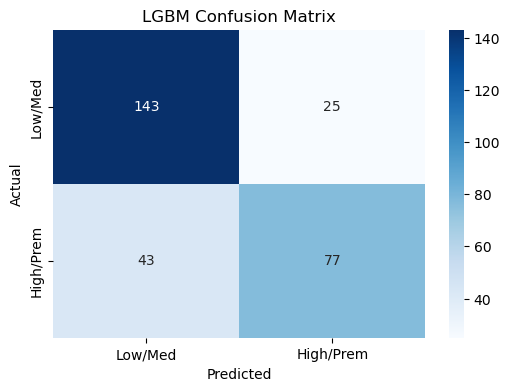

In [2096]:
# Evaluate best model

from sklearn.metrics import confusion_matrix, roc_auc_score

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

roc_auc = roc_auc_score(y_test, y_prob)
print(f"ROC AUC: {roc_auc:.3f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low/Med', 'High/Prem'],
            yticklabels=['Low/Med', 'High/Prem'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('LGBM Confusion Matrix')
plt.show()



The model works sufficiently well, especially in terms of precision with customers being flagged as high/premium having a low probability of actually being low/medium, so customer acquisition should be able to use that as a pretty strong indicator of a high value customer being acquired.

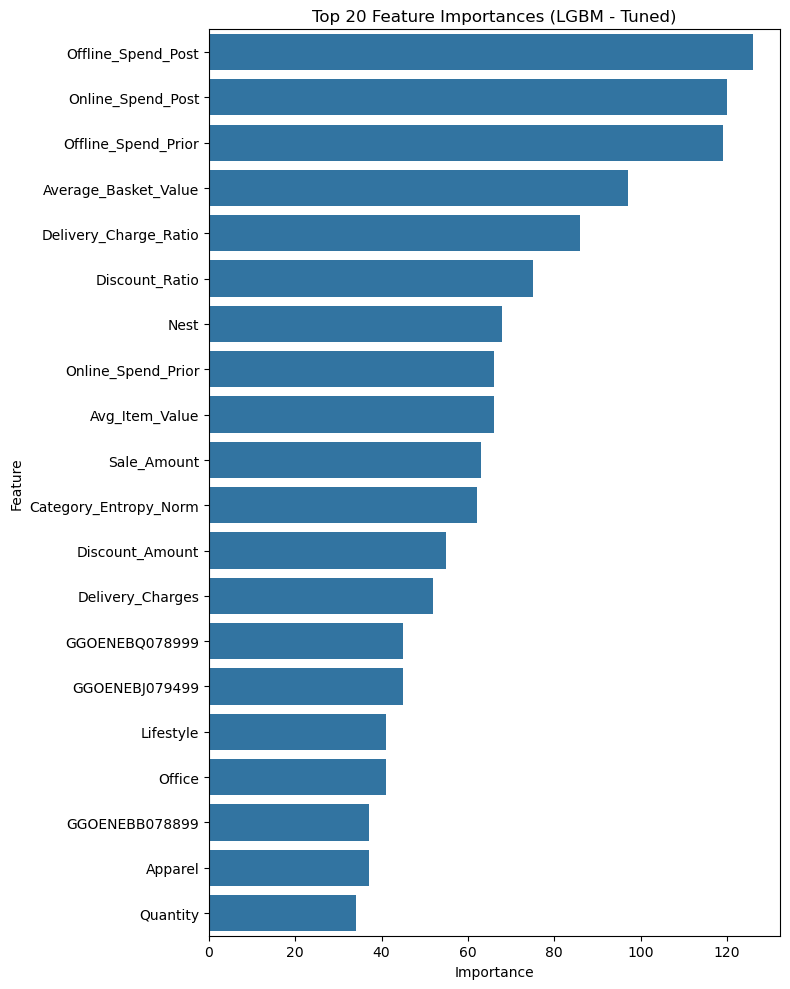

In [2097]:
# Feature importance

importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': best_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(8, 10))
sns.barplot(data=importance.head(20), x='Importance', y='Feature')
plt.title('Top 20 Feature Importances (LGBM - Tuned)')
plt.tight_layout()
plt.show()

As we can see, the marketing spend both the month before and especially during their first month has a big impact of the model. This further strengthens the earlier discovery of a high connection between marketing spend and revenue. Other features with high importance include the average basket value and other revenue based features. The product specific features also appear in the top, with especially the Nest product category appearing high up. This is not suprising as we saw many Nest products in the top products in terms of total revenue for the company.

## 5 Market basket analysis

For this part, we will do market basket analysis to determine which products are often sold together and aim to produce a list of products that could be bundeled together for cross-selling purposes.

In [ ]:
# Group products sold by transaction
basket_data = sales_v2.groupby('Transaction_ID')['Product_Description'].apply(list).reset_index()
basket_data.head()


,Transaction_ID,Product_Description
0,16679,[Nest Learning Thermostat 3rd Gen-USA - Stainl...
1,16680,[Nest Learning Thermostat 3rd Gen-USA - Stainl...
2,16681,[Google Laptop and Cell Phone Stickers]
3,16682,"[Google Canvas Tote Natural/Navy, Sport Bag, E..."
4,16684,[Nest Protect Smoke + CO White Wired Alarm-USA...


In [ ]:
# Turn into list format
transaction_baskets = basket_data['Product_Description'].tolist()
transaction_baskets[:5]

[['Nest Learning Thermostat 3rd Gen-USA - Stainless Steel'],
 ['Nest Learning Thermostat 3rd Gen-USA - Stainless Steel'],
 ['Google Laptop and Cell Phone Stickers'],
 ['Google Canvas Tote Natural/Navy',
  'Sport Bag',
  'Engraved Ceramic Google Mug',
  'Maze Pen',
  "YouTube Men's Short Sleeve Hero Tee Black",
  "Google Men's 100% Cotton Short Sleeve Hero Tee Black",
  'Google 22 oz Water Bottle',
  'Google Infuser-Top Water Bottle',
  'Galaxy Screen Cleaning Cloth',
  'Badge Holder'],
 ['Nest Protect Smoke + CO White Wired Alarm-USA',
  'Nest Cam Outdoor Security Camera - USA']]

In [ ]:
# Convert to One-Hot Format
from mlxtend.preprocessing import TransactionEncoder
te = TransactionEncoder()
te_array = te.fit(transaction_baskets).transform(transaction_baskets)
df_encoded = pd.DataFrame(te_array, columns=te.columns_)

In [ ]:
# Identifying support and confidence levels that yield actionable number of asscociation rules

from mlxtend.frequent_patterns import apriori, association_rules

# For 10% confidence

print("10% Confidence Level")

for support in [0.02, 0.01, 0.005, 0.001]:
    baskets = apriori(df_encoded, min_support=support, use_colnames=True)
    rules = association_rules(baskets, metric='confidence', min_threshold=0.1)
    print(support, baskets.shape[0], rules.shape[0])

print()

# For 20% confidence

print("20% Confidence Level")

for support in [0.02, 0.01, 0.005, 0.001]:
    baskets = apriori(df_encoded, min_support=support, use_colnames=True)
    rules = association_rules(baskets, metric='confidence', min_threshold=0.2)
    print(support, baskets.shape[0], rules.shape[0])

print()

# For 30% confidence
print("30% Confidence Level")

for support in [0.02, 0.01, 0.005, 0.001]:
    baskets = apriori(df_encoded, min_support=support, use_colnames=True)
    rules = association_rules(baskets, metric='confidence', min_threshold=0.3)
    print(support, baskets.shape[0], rules.shape[0])




10% Confidence Level
0.02 14 2
0.01 41 2
0.005 95 8
0.001 545 281

20% Confidence Level
0.02 14 2
0.01 41 2
0.005 95 3
0.001 545 97

30% Confidence Level
0.02 14 0
0.01 41 0
0.005 95 1
0.001 545 25


It seems like we need to use a quite low support level of 0.001 in order to get any decent number of association rules, meaning they do not currently show up in a large share of transactions. High cost cross-selling campaigns are therefore not recommended, but building scalable cross-selling nudging mechanisms for these items in the webstore could provide a small boost. 

In [ ]:
# Displaying rules with with 0.1% support and 30% confidence
baskets = apriori(df_encoded, min_support=0.001, use_colnames=True)
rules = association_rules(baskets, metric='confidence', min_threshold=0.3)
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values('support', ascending=False)

,antecedents,consequents,support,confidence,lift
8,(YouTube Custom Decals),(Google Laptop and Cell Phone Stickers),0.005347,0.319809,9.943840
6,(Google Doodle Decal),(Google Laptop and Cell Phone Stickers),0.004908,0.384375,11.951392
5,(Android Sticker Sheet Ultra Removable),(Google Laptop and Cell Phone Stickers),0.003871,0.470874,14.640903
3,(8 pc Android Sticker Sheet),(Google Laptop and Cell Phone Stickers),0.003591,0.348837,10.846414
20,"(Nest Cam Indoor Security Camera - USA, Nest L...",(Nest Cam Outdoor Security Camera - USA),0.003392,0.372807,2.807367
7,(Keyboard DOT Sticker),(Google Laptop and Cell Phone Stickers),0.002913,0.388298,12.073366
0,(22 oz Android Bottle),(Google 22 oz Water Bottle),0.002594,0.467626,17.133293
2,(Android Sticker Sheet Ultra Removable),(8 pc Android Sticker Sheet),0.002594,0.315534,30.649601
23,"(Nest Cam Outdoor Security Camera - USA, Nest ...",(Nest Cam Indoor Security Camera - USA),0.002594,0.338542,2.626685
22,"(Nest Cam Indoor Security Camera - USA, Nest P...",(Nest Cam Outdoor Security Camera - USA),0.002594,0.433333,3.263151


## 6 Cohort analysis

For this part we will construct customer cohorts based on the month of first purchase and study retention month over month.



In [66]:
# Adding cohort month to sales dataframe
sales_v2['Cohort_Month'] = sales_v2.groupby('CustomerID')['Month'].transform('min')
sales_v2.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,Month,Discount_pct,GST,Sale_Amount,Cohort_Month
0,17850,16679,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,2019-01,0.1,0.10,158.67,2019-01
1,17850,16680,2019-01-01,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.5,Used,2019-01,0.1,0.10,158.67,2019-01
2,17850,16681,2019-01-01,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.5,Used,2019-01,0.1,0.10,8.53,2019-01
3,17850,16682,2019-01-01,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.5,Used,2019-01,0.1,0.18,24.02,2019-01
4,17850,16682,2019-01-01,GGOEGBMJ013399,Sport Bag,Bags,15,5.15,6.5,Used,2019-01,0.1,0.18,88.54,2019-01


In [67]:
# Preparing a cohort analysis table
cohort_data = sales_v2.groupby(['Cohort_Month', 'Month'])['CustomerID'].nunique().reset_index()
cohort_data

,Cohort_Month,Month,CustomerID
0,2019-01,2019-01,215
1,2019-01,2019-02,13
2,2019-01,2019-03,24
3,2019-01,2019-04,34
4,2019-01,2019-05,23
...,...,...,...
73,2019-10,2019-11,6
74,2019-10,2019-12,4
75,2019-11,2019-11,68
76,2019-11,2019-12,7


In [68]:
# Adding cohort period to cohort_data
cohort_data['Cohort_Period'] = (cohort_data['Month'].dt.month - cohort_data['Cohort_Month'].dt.month)
cohort_data

,Cohort_Month,Month,CustomerID,Cohort_Period
0,2019-01,2019-01,215,0
1,2019-01,2019-02,13,1
2,2019-01,2019-03,24,2
3,2019-01,2019-04,34,3
4,2019-01,2019-05,23,4
...,...,...,...,...
73,2019-10,2019-11,6,1
74,2019-10,2019-12,4,2
75,2019-11,2019-11,68,0
76,2019-11,2019-12,7,1


In [69]:
# Creating a cohort matrix
cohort_counts = cohort_data.pivot_table(index='Cohort_Month', columns='Cohort_Period', values='CustomerID')
cohort_counts

Cohort_Period,0,1,2,3,4,5,6,7,8,9,10,11
Cohort_Month,,,,,,,,,,,,
2019-01,215.0,13.0,24.0,34.0,23.0,44.0,35.0,47.0,23.0,28.0,20.0,34.0
2019-02,96.0,7.0,9.0,16.0,17.0,22.0,19.0,15.0,12.0,11.0,16.0,NaN
2019-03,177.0,18.0,35.0,25.0,32.0,33.0,22.0,22.0,15.0,19.0,NaN,NaN
2019-04,163.0,14.0,24.0,24.0,18.0,15.0,10.0,16.0,12.0,NaN,NaN,NaN
2019-05,112.0,12.0,9.0,13.0,10.0,13.0,14.0,8.0,NaN,NaN,NaN,NaN
2019-06,137.0,20.0,22.0,12.0,11.0,14.0,11.0,NaN,NaN,NaN,NaN,NaN
2019-07,94.0,13.0,4.0,6.0,11.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-08,135.0,14.0,15.0,10.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09,78.0,6.0,3.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [70]:
# Transforming cohort counts to retention rates
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)

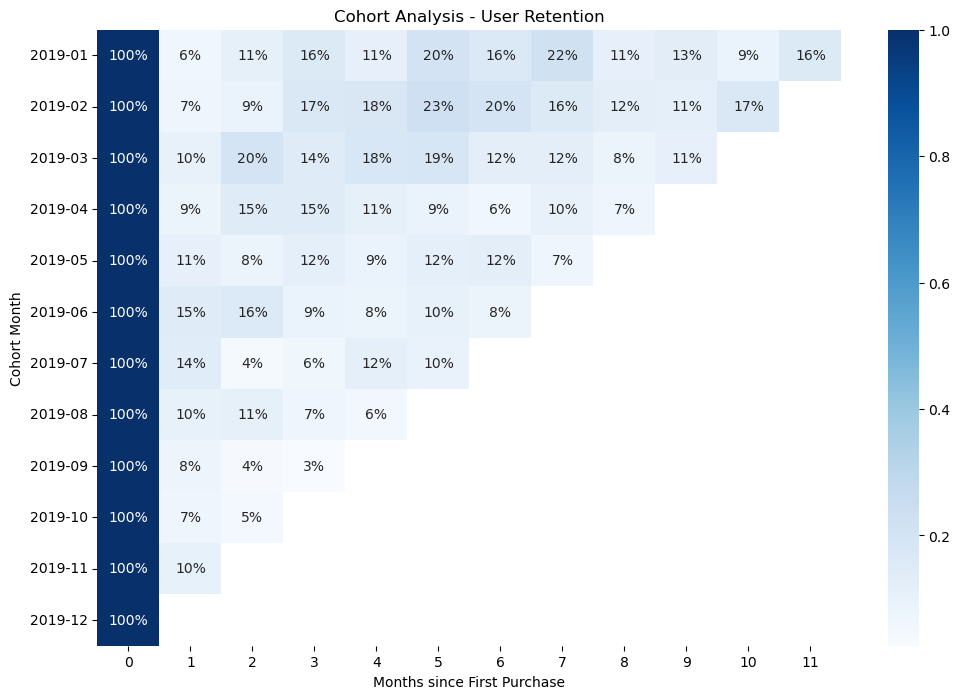

In [71]:
# Plotting the retention heatmap
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
plt.figure(figsize=(12, 8))
sns.heatmap(retention, annot=True, fmt='.0%', cmap='Blues')
plt.title('Cohort Analysis - User Retention')
plt.ylabel('Cohort Month')
plt.xlabel('Months since First Purchase')
plt.show()

We can see that the retention of customers acquired earlier in the year was generally a big better than later in the year. We can also see a pattern of general volatility in terms of that the retention of each cohort tends to go up and down, indicating that the customer base includes many customers who don't purchase each month.